In [ ]:
import os
import numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from torchsummary import summary
import torch.nn.functional as F
from sklearn.model_selection import KFold
from sklearn import preprocessing
import matplotlib.pyplot as plt
import math
import sklearn
!CUBLAS_WORKSPACE_CONFIG=:16:8

# !pip install memtorch
# import memtorch
# import copy
# from memtorch.mn.Module import patch_model
# from memtorch.map.Parameter import naive_map
# from memtorch.bh.crossbar.Program import naive_program

In [ ]:
from tensorflow.python.client import device_lib
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using {} device'.format(device),'\n')
print('Device Details')
print(device_lib.list_local_devices())

Using cuda device 

Device Details
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 4259028450466387670
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 11345264640
locality {
  bus_id: 1
  links {
  }
}
incarnation: 13326803034382949403
physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"
]


In [ ]:
### Data Loading

torch.manual_seed(42)
np.random.seed(42)
torch.backends.cudnn.benchmark = False
torch.use_deterministic_algorithms(True)
torch.backends.cudnn.deterministic = True
os.environ['PYTHONHASHSEED'] = str(42)

SetA = np.load('/content/drive/My Drive/ISML/BonnDatasetWindow64/SetA.npy')
SetE = np.load('/content/drive/My Drive/ISML/BonnDatasetWindow64/SetE.npy')

fileLength = 4096
window = 64
numFold = 5
bS = 32

#SetA is normal, labeled as 0
#SetE is ictal, labeled as 1
allData = SetA
allData = np.append(allData,SetE,axis=0)
allLabel = np.zeros((int(100*fileLength/window),1))
allLabel = np.append(allLabel,np.ones((int(100*fileLength/window),1)),axis=0)
allLabel = allLabel.astype(int)

oneHot = []
for i in allLabel:
  if i==0:
    oneHot.append([1,0])
  else:
    oneHot.append([0,1])

allLabel = oneHot
allLabel= np.asarray(allLabel)
randInd = np.arange(0,len(allData))
np.random.shuffle(randInd)
allData = allData[randInd]
allLabel = allLabel[randInd]

foldsData = np.split(allData,numFold)
foldsLabel = np.split(allLabel,numFold)

trainData = np.concatenate(foldsData[0:-1])
trainLabel = np.concatenate(foldsLabel[0:-1])
testData = foldsData[-1]
testLabel = foldsLabel[-1]

trainData = np.expand_dims(trainData,1)
testData = np.expand_dims(testData,1)

trainData = torch.tensor(trainData)
testData = torch.tensor(testData)
trainLabel = torch.tensor(trainLabel)
testLabel = torch.tensor(testLabel)

print(testLabel.shape)

torch.Size([2560, 2])


In [ ]:
### Network Definition


class ParallelConvolution(nn.Module):
    def __init__(self,size):
        super(ParallelConvolution, self).__init__()
        self.conv1 = nn.Conv1d(1,32,size)
        self.conv2 = nn.Conv1d(1,32,62-size)
        self.avgpool = nn.AvgPool1d(2)
        self.flatten = nn.Flatten()
        self.dropout = nn.Dropout(0.5)
        self.linear = nn.Linear(1088,8)
        self.classification = nn.Linear(8,2)

    def forward(self,x):
        out1 = F.relu(self.conv1(x))
        out2 = F.relu(self.conv2(x))
        x = torch.cat((out1, out2),dim=2)
        x = self.avgpool(x)
        x = self.flatten(x)
        x = self.dropout(x)
        x = self.linear(x)
        out = self.classification(x)
        return out
      
    

model = ParallelConvolution(27)
model = model.to(device)
# summary(model,(1,64))
# for name, param in model.named_parameters():
#     print(name,param.shape)

In [ ]:
### Network convolution kernel size search 5 to 31

num_epoch = 400

torch.manual_seed(42)
np.random.seed(42)
torch.backends.cudnn.benchmark = False
torch.use_deterministic_algorithms(True)
torch.backends.cudnn.deterministic = True
os.environ['PYTHONHASHSEED'] = str(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)
    
kernel_size = [5,10,15,20,25,26,27,28,29,30,31]

loss_function = nn.BCEWithLogitsLoss()



for ker in kernel_size:
    print('--------------------------------')
    print(f'Kernel Size {ker}')
    print('--------------------------------')

    network = ParallelConvolution(ker)
    network.to(device,dtype=torch.float)

    optimizer = torch.optim.Adam(network.parameters())
    
    lossHist = []
    testAccHist = []
    trainAccHist = []
    bestAcc = 0
    bestEpoch = 0
    for epoch in range(num_epoch):
        trainCorrect = 0
        trainTotal = 0
        testCorrect = 0
        testTotal = 0 

        for i in range(0,len(trainData),bS):
            data = trainData[i:i+bS].to(device,dtype=torch.float)
            label = trainLabel[i:i+bS].to(device,dtype=torch.float)

            # Zero the gradients
            optimizer.zero_grad()
            network.eval()
            # Perform forward pass
            outputs = network(data)
            network.train()
            # Compute loss
            loss = loss_function(outputs, label)
            
            # Perform backward pass
            loss.backward()
            
            # Perform optimization
            optimizer.step()
            network.eval()
            # # Print statistics
            # current_loss += loss.item()
            trainCorrect += np.sum(np.argmax(outputs.cpu().detach().numpy(),axis=1)==np.argmax(label.cpu().detach().numpy(),axis=1))
            trainTotal += len(outputs)
        

        for i in range(0,len(testData),bS):
            data = testData[i:i+bS].to(device,dtype=torch.float)
            label = testLabel[i:i+bS].to(device,dtype=torch.float)

            network.eval()
            # Perform forward pass
            outputs = network(data)
            #Caclulate statistics
            testCorrect += np.sum(np.argmax(outputs.cpu().detach().numpy(),axis=1)==np.argmax(label.cpu().detach().numpy(),axis=1))
            testTotal += len(outputs)
            #print(label)     
            
        if testCorrect/testTotal > bestAcc:
            # torch.save(network,'/content/drive/MyDrive/ISML Final Paper Files/ModelCheckpoint/'+'Fold'+str(fold)+'Epoch'+str(epoch))
            # bestAcc = testCorrect/testTotal
            torch.save(network.state_dict(),'/content/drive/MyDrive/ISML Final Paper Files/ModelCheckpoint/Kernel{}Epoch{}'.format(ker,epoch))
            bestAcc = testCorrect/testTotal
            bestEpoch = epoch
            #print(network.state_dict())
            #print(testCorrect)

        print('Epoch:',epoch,'Loss:', loss.item(), 'Train Accuracy:', trainCorrect/trainTotal, 'Test Accuracy:', testCorrect/testTotal)
        lossHist.append(loss)
        trainAccHist.append(trainCorrect/trainTotal)
        testAccHist.append(testCorrect/testTotal)

    plt.figure(1)
    plt.plot(np.arange(num_epoch),lossHist,label=str(ker))
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.figure(2)
    plt.plot(np.arange(num_epoch),trainAccHist,label=str(ker))
    plt.xlabel('Epoch')
    plt.ylabel('Train Accuracy')
    plt.legend()
    plt.figure(3)
    plt.plot(np.arange(num_epoch),testAccHist,label=str(ker))
    plt.xlabel('Epoch')
    plt.ylabel('Test Accuracy')
    plt.legend()
    print('Best Accuracy:', bestAcc, 'at epoch:', bestEpoch)

Streaming output truncated to the last 5000 lines.
Epoch: 249 Loss: 3.669397585781553e-07 Train Accuracy: 1.0 Test Accuracy: 1.0
Epoch: 250 Loss: 3.31549756538152e-07 Train Accuracy: 1.0 Test Accuracy: 1.0
Epoch: 251 Loss: 2.980223712256702e-07 Train Accuracy: 1.0 Test Accuracy: 1.0
Epoch: 252 Loss: 2.6449492906976957e-07 Train Accuracy: 1.0 Test Accuracy: 1.0
Epoch: 253 Loss: 2.3096750112472364e-07 Train Accuracy: 1.0 Test Accuracy: 1.0
Epoch: 254 Loss: 1.9930267569634452e-07 Train Accuracy: 1.0 Test Accuracy: 1.0
Epoch: 255 Loss: 1.657751624861703e-07 Train Accuracy: 1.0 Test Accuracy: 1.0
Epoch: 256 Loss: 1.396982156620652e-07 Train Accuracy: 1.0 Test Accuracy: 1.0
Epoch: 257 Loss: 1.1734653071471257e-07 Train Accuracy: 1.0 Test Accuracy: 1.0
Epoch: 258 Loss: 1.0244539794257435e-07 Train Accuracy: 1.0 Test Accuracy: 1.0
Epoch: 259 Loss: 8.568162002120516e-08 Train Accuracy: 1.0 Test Accuracy: 1.0
Epoch: 260 Loss: 6.705518273975031e-08 Train Accuracy: 1.0 Test Accuracy: 1.0
Epoch: 26

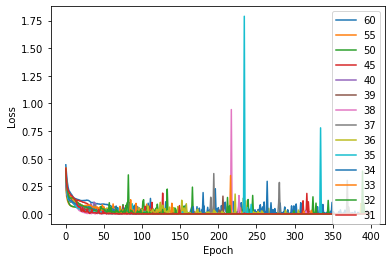

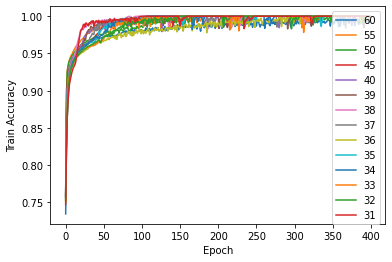

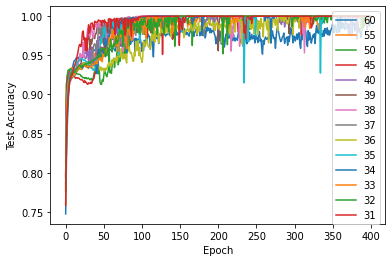

In [ ]:
### Network convolution kernel size search 31 to 60

num_epoch = 400

torch.manual_seed(42)
np.random.seed(42)
torch.backends.cudnn.benchmark = False
torch.use_deterministic_algorithms(True)
torch.backends.cudnn.deterministic = True
os.environ['PYTHONHASHSEED'] = str(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)
    
kernel_size = [60,55,50,45,40,39,38,37,36,35,34,33,32,31]

loss_function = nn.BCEWithLogitsLoss()



for ker in kernel_size:
    print('--------------------------------')
    print(f'Kernel Size {ker}')
    print('--------------------------------')

    network = ParallelConvolution(ker)
    network.to(device,dtype=torch.float)

    optimizer = torch.optim.Adam(network.parameters())
    
    lossHist = []
    testAccHist = []
    trainAccHist = []
    bestAcc = 0
    bestEpoch = 0
    for epoch in range(num_epoch):
        trainCorrect = 0
        trainTotal = 0
        testCorrect = 0
        testTotal = 0 

        for i in range(0,len(trainData),bS):
            data = trainData[i:i+bS].to(device,dtype=torch.float)
            label = trainLabel[i:i+bS].to(device,dtype=torch.float)

            # Zero the gradients
            optimizer.zero_grad()
            network.eval()
            # Perform forward pass
            outputs = network(data)
            network.train()
            # Compute loss
            loss = loss_function(outputs, label)
            
            # Perform backward pass
            loss.backward()
            
            # Perform optimization
            optimizer.step()
            network.eval()
            # # Print statistics
            # current_loss += loss.item()
            trainCorrect += np.sum(np.argmax(outputs.cpu().detach().numpy(),axis=1)==np.argmax(label.cpu().detach().numpy(),axis=1))
            trainTotal += len(outputs)
        

        for i in range(0,len(testData),bS):
            data = testData[i:i+bS].to(device,dtype=torch.float)
            label = testLabel[i:i+bS].to(device,dtype=torch.float)

            network.eval()
            # Perform forward pass
            outputs = network(data)
            #Caclulate statistics
            testCorrect += np.sum(np.argmax(outputs.cpu().detach().numpy(),axis=1)==np.argmax(label.cpu().detach().numpy(),axis=1))
            testTotal += len(outputs)
            #print(label)     
            
        if testCorrect/testTotal > bestAcc:
            # torch.save(network,'/content/drive/MyDrive/ISML Final Paper Files/ModelCheckpoint/'+'Fold'+str(fold)+'Epoch'+str(epoch))
            # bestAcc = testCorrect/testTotal
            torch.save(network.state_dict(),'/content/drive/MyDrive/ISML Final Paper Files/ModelCheckpoint/Kernel{}Epoch{}'.format(ker,epoch))
            bestAcc = testCorrect/testTotal
            bestEpoch = epoch
            #print(network.state_dict())
            #print(testCorrect)

        print('Epoch:',epoch,'Loss:', loss.item(), 'Train Accuracy:', trainCorrect/trainTotal, 'Test Accuracy:', testCorrect/testTotal)
        lossHist.append(loss)
        trainAccHist.append(trainCorrect/trainTotal)
        testAccHist.append(testCorrect/testTotal)

    plt.figure(1)
    plt.plot(np.arange(num_epoch),lossHist,label=str(ker))
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.figure(2)
    plt.plot(np.arange(num_epoch),trainAccHist,label=str(ker))
    plt.xlabel('Epoch')
    plt.ylabel('Train Accuracy')
    plt.legend()
    plt.figure(3)
    plt.plot(np.arange(num_epoch),testAccHist,label=str(ker))
    plt.xlabel('Epoch')
    plt.ylabel('Test Accuracy')
    plt.legend()
    print('Best Accuracy:', bestAcc, 'at epoch:', bestEpoch)

Streaming output truncated to the last 5000 lines.

Epoch: 202 Train Loss: 1.8626446163239052e-08
Train Accuracy: 1.0 Train Sensitivity: 1.0 Train Specitivity: 1.0 Train FP Count: 0.0 Train AUROC: 1.0
Test Accuracy: 1.0 Test Sensitivity: 1.0 Test Specitivity: 1.0 Test FP Count: 0.0 Test AUROC: 1.0


Epoch: 203 Train Loss: 1.8626446163239052e-08
Train Accuracy: 1.0 Train Sensitivity: 1.0 Train Specitivity: 1.0 Train FP Count: 0.0 Train AUROC: 1.0
Test Accuracy: 1.0 Test Sensitivity: 1.0 Test Specitivity: 1.0 Test FP Count: 0.0 Test AUROC: 1.0


Epoch: 204 Train Loss: 1.8626446163239052e-08
Train Accuracy: 1.0 Train Sensitivity: 1.0 Train Specitivity: 1.0 Train FP Count: 0.0 Train AUROC: 1.0
Test Accuracy: 1.0 Test Sensitivity: 1.0 Test Specitivity: 1.0 Test FP Count: 0.0 Test AUROC: 1.0


Epoch: 205 Train Loss: 1.8626446163239052e-08
Train Accuracy: 1.0 Train Sensitivity: 1.0 Train Specitivity: 1.0 Train FP Count: 0.0 Train AUROC: 1.0
Test Accuracy: 1.0 Test Sensitivity: 1.0 Test Specit

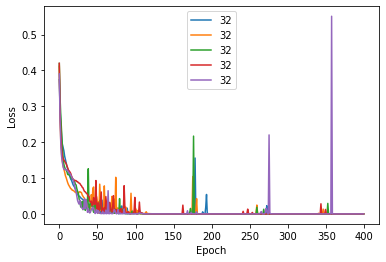

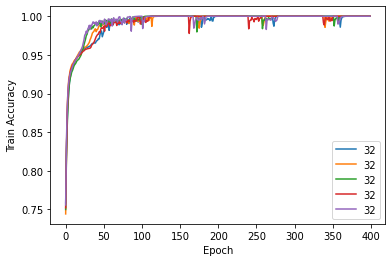

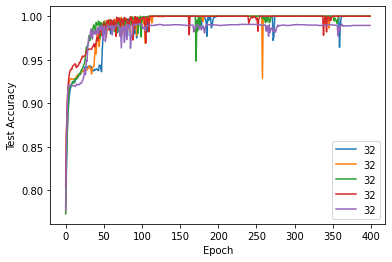

In [ ]:
### 5-fold Cross Validation


torch.manual_seed(8)
np.random.seed(8)
torch.backends.cudnn.benchmark = False
torch.use_deterministic_algorithms(False)
torch.backends.cudnn.deterministic = True
os.environ['PYTHONHASHSEED'] = str(8)
!CUBLAS_WORKSPACE_CONFIG=:16:8


SetA = np.load('/content/drive/My Drive/ISML/BonnDatasetWindow64/SetA.npy')
SetE = np.load('/content/drive/My Drive/ISML/BonnDatasetWindow64/SetE.npy')

fileLength = 4096
window = 64
numFold = 5
bS = 32

#SetA is normal, labeled as 0
#SetE is ictal, labeled as 1
allData = SetA
allData = np.append(allData,SetE,axis=0)
allLabel = np.zeros((int(100*fileLength/window),1))
allLabel = np.append(allLabel,np.ones((int(100*fileLength/window),1)),axis=0)
allLabel = allLabel.astype(int)

oneHot = []
for i in allLabel:
  if i==0:
    oneHot.append([1,0])
  else:
    oneHot.append([0,1])

allLabel = oneHot
allLabel= np.asarray(allLabel)
randInd = np.arange(0,len(allData))
np.random.shuffle(randInd)
allData = allData[randInd]
allLabel = allLabel[randInd]

foldsData = np.split(allData,numFold)
foldsLabel = np.split(allLabel,numFold)

#print(foldsData[4].shape)

def foldretrieve(fold,foldsData,foldsLabel):
    testData = foldsData[fold]
    testLabel = foldsLabel[fold]
    allData = foldsData[0:fold]+foldsData[fold:-1]
    allLabel = foldsLabel[0:fold]+foldsLabel[fold:-1]
    trainData = np.concatenate([*allData])
    trainLabel = np.concatenate([*allLabel])

    trainData = np.expand_dims(trainData,1)
    testData = np.expand_dims(testData,1)

    trainData = torch.tensor(trainData)
    testData = torch.tensor(testData)
    trainLabel = torch.tensor(trainLabel)
    testLabel = torch.tensor(testLabel)
    return trainData,testData,trainLabel,testLabel

#trainData,testData,trainLabel,testLabel = foldretrieve(0,foldsData,foldsLabel)
#print(trainData.shape,testData.shape)


num_epoch = 400
    
ker = 32

loss_function = nn.BCEWithLogitsLoss()


for fold in range(0,numFold):
    trainData,testData,trainLabel,testLabel = foldretrieve(fold,foldsData,foldsLabel)

    print('--------------------------------')
    print(f'Fold Number {fold}')
    print('--------------------------------')

    network = ParallelConvolution(ker)
    network.to(device,dtype=torch.float)

    optimizer = torch.optim.Adam(network.parameters())
    
    lossHist = []
    testAccHist = []
    trainAccHist = []
    bestAcc = 0
    bestSen = 0
    bestSpe = 0
    bestFPC = 1e10
    bestAUR = 0
    bestEpoch = [0,0,0,0,0]
    for epoch in range(num_epoch):
        trainCorrect = 0
        trainTotal = 0
        testCorrect = 0
        testTotal = 0 

        trainOutputs = np.empty((0,1))
        trainLabels = np.empty((0,1))
        trainCM = np.zeros((2, 2))
        
        testOutputs = np.empty((0,1))
        testLabels = np.empty((0,1))
        testCM = np.zeros((2, 2))

        for i in range(0,len(trainData),bS):
            data = trainData[i:i+bS].to(device,dtype=torch.float)
            label = trainLabel[i:i+bS].to(device,dtype=torch.float)

            # Zero the gradients
            optimizer.zero_grad()
            network.eval()
            # Perform forward pass
            outputs = network(data)
            network.train()
            # Compute loss
            loss = loss_function(outputs, label)
            
            # Perform backward pass
            loss.backward()
            
            # Perform optimization
            optimizer.step()
            network.eval()
            
            outputs = outputs.cpu().detach().numpy()
            label = label.cpu().detach().numpy()

            outputs = np.argmax(outputs,axis=1)
            label = np.argmax(label,axis=1)

            trainCM = np.add(trainCM, sklearn.metrics.confusion_matrix(outputs, label, labels=[0, 1]))

            trainCorrect += np.sum(outputs==label)
            trainTotal += len(outputs)

            trainOutputs = np.append(trainOutputs,outputs.reshape((-1,1)),axis=0)
            trainLabels = np.append(trainLabels,label.reshape((-1,1)),axis=0)

        for i in range(0,len(testData),bS):
            data = testData[i:i+bS].to(device,dtype=torch.float)
            label = testLabel[i:i+bS].to(device,dtype=torch.float)

            network.eval()
            # Perform forward pass
            outputs = network(data)
            #Caclulate statistics
            testCorrect += np.sum(np.argmax(outputs.cpu().detach().numpy(),axis=1)==np.argmax(label.cpu().detach().numpy(),axis=1))
            testTotal += len(outputs)
            #print(label)
            outputs = outputs.cpu().detach().numpy()
            label = label.cpu().detach().numpy()

            outputs = np.argmax(outputs,axis=1)
            label = np.argmax(label,axis=1)

            testCM = np.add(testCM, sklearn.metrics.confusion_matrix(outputs, label, labels=[0, 1]))

            testCorrect += np.sum(outputs==label)
            testTotal += len(outputs)

            testOutputs = np.append(testOutputs,outputs.reshape((-1,1)),axis=0)
            testLabels = np.append(testLabels,label.reshape((-1,1)),axis=0)     
            
        if testCorrect/testTotal > bestAcc:
            # torch.save(network,'/content/drive/MyDrive/ISML Final Paper Files/ModelCheckpoint/'+'Fold'+str(fold)+'Epoch'+str(epoch))
            # bestAcc = testCorrect/testTotal
            torch.save(network.state_dict(),'/content/drive/MyDrive/ISML Final Paper Files/ModelCheckpointBonn/Kernel{}Epoch{}'.format(ker,epoch))
            #print(network.state_dict())
            #print(testCorrect)

        trainF1 = sklearn.metrics.f1_score(trainLabels,trainOutputs)
        trainAccuracy = trainCorrect/trainTotal
        trainTN, trainFP, trainFN, trainTP = trainCM.ravel()
        trainSensitivity = trainTP / (trainTP+trainFN)
        trainSpecitivity = trainTN / (trainTN+trainFP)
        try:
          trainAUROC = sklearn.metrics.roc_auc_score(trainLabels, trainOutputs)
        except:
          trainAUROC = 0.


        trainF1 = sklearn.metrics.f1_score(trainLabels,trainOutputs)
        trainAccuracy = trainCorrect/trainTotal
        trainTN, trainFP, trainFN, trainTP = trainCM.ravel()
        trainSensitivity = trainTP / (trainTP+trainFN)
        trainSpecitivity = trainTN / (trainTN+trainFP)
        try:
          trainAUROC = sklearn.metrics.roc_auc_score(trainLabels, trainOutputs)
        except:
          trainAUROC = 0.


        testF1 = sklearn.metrics.f1_score(testLabels,testOutputs)
        testAccuracy = testCorrect/testTotal
        testTN, testFP, testFN, testTP = testCM.ravel()
        testSensitivity = testTP / (testTP+testFN)
        testSpecitivity = testTN / (testTN+testFP)
        try:
          testAUROC = sklearn.metrics.roc_auc_score(testLabels, testOutputs)
        except:
          testAUROC = 0.


        if testAccuracy > bestAcc:
          bestAcc = testAccuracy
          bestEpoch[0] = epoch
        if testSensitivity > bestSen:
          bestSen = testSensitivity
          bestEpoch[1] = epoch
        if testSpecitivity > bestSpe:
          bestSpe = testSpecitivity
          bestEpoch[2] = epoch
        if testFP < bestFPC:
          bestFPC = testFP
          bestEpoch[3] = epoch
        if testAUROC > bestAUR:
          bestAUR = testAUROC
          bestEpoch[4] = epoch

        print('Epoch:', epoch, 'Train Loss:', loss.item())
        print('Train Accuracy:', trainAccuracy, 'Train Sensitivity:', trainSensitivity, 'Train Specitivity:', trainSpecitivity, 'Train FP Count:', trainFP, 'Train AUROC:', trainAUROC)
        print('Test Accuracy:', testAccuracy, 'Test Sensitivity:', testSensitivity, 'Test Specitivity:', testSpecitivity, 'Test FP Count:', testFP, 'Test AUROC:', testAUROC,)
        print('\n')
        lossHist.append(loss)
        trainAccHist.append(trainCorrect/trainTotal)
        testAccHist.append(testCorrect/testTotal)

    plt.figure(1)
    plt.plot(np.arange(num_epoch),lossHist,label=str(ker))
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.figure(2)
    plt.plot(np.arange(num_epoch),trainAccHist,label=str(ker))
    plt.xlabel('Epoch')
    plt.ylabel('Train Accuracy')
    plt.legend()
    plt.figure(3)
    plt.plot(np.arange(num_epoch),testAccHist,label=str(ker))
    plt.xlabel('Epoch')
    plt.ylabel('Test Accuracy')
    plt.legend()
    print('Best Accuracy:', bestAcc, 'at epoch:', bestEpoch)

In [ ]:
### Loading checkpoint and double check on result

torch.manual_seed(42)
np.random.seed(42)
torch.backends.cudnn.benchmark = False
torch.use_deterministic_algorithms(True)
torch.backends.cudnn.deterministic = True
os.environ['PYTHONHASHSEED'] = str(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

network = ParallelConvolution(27)
network.load_state_dict(torch.load('/content/drive/MyDrive/ISML Final Paper Files/ModelCheckpoint/Kernel{}Epoch{}'.format(27,343)))
network.to(device)
network.eval()


testCorrect = 0
testTotal = 0 


for i in range(0,len(testData),bS):
    data = testData[i:i+bS].to(device,dtype=torch.float)
    label = testLabel[i:i+bS].to(device,dtype=torch.float)

    network.eval()
    # Perform forward pass
    outputs = network(data)
    #Caclulate statistics
    testCorrect += np.sum(np.argmax(outputs.cpu().detach().numpy(),axis=1)==np.argmax(label.cpu().detach().numpy(),axis=1))
    testTotal += len(outputs)  
            

print('Test Accuracy:', testCorrect/testTotal)

Test Accuracy: 0.992578125


In [ ]:
### Please ignore cells below, they are from earlier experiments

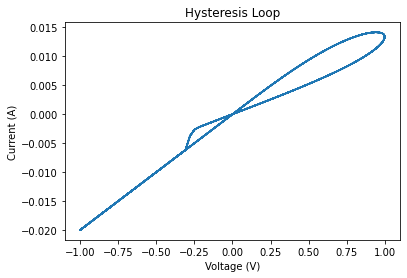

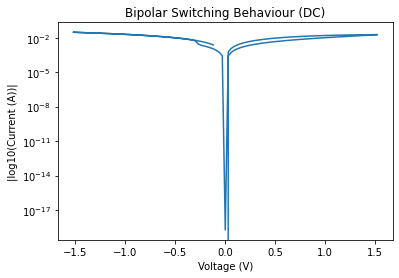

Patched Linear(in_features=1088, out_features=8, bias=True) -> bh.Linear(in_features=1088, out_features=8, bias=True)
Patched Linear(in_features=8, out_features=2, bias=True) -> bh.Linear(in_features=8, out_features=2, bias=True)
Tuned bh.Linear(in_features=1088, out_features=8, bias=True). Coefficient of determination: 0.999962 [5.318214, 0.000012]
Tuned bh.Linear(in_features=8, out_features=2, bias=True). Coefficient of determination: 0.999982 [60.608639, -0.000051]


NameError: ignored

In [ ]:
def test(model, test_loader):
    testTotal = 0
    testCorrect = 0
    for i, (data,label) in enumerate(testloader):
        data = data.to(device,dtype=torch.float)
        label = label.to(device,dtype=torch.float)
        
        # Perform forward pass
        outputs = network(data)

        #Caclulate statistics
        testCorrect += np.sum(np.argmax(outputs.cpu().detach().numpy(),axis=1)==np.argmax(label.cpu().detach().numpy(),axis=1))
        testTotal += len(outputs)
    print(testCorrect,testTotal)
    return testCorrect/testTotal*100

reference_memristor = memtorch.bh.memristor.VTEAM
reference_memristor_params = {'time_series_resolution': 1e-10}
memristor = reference_memristor(**reference_memristor_params)
memristor.plot_hysteresis_loop()
memristor.plot_bipolar_switching_behaviour()

patched_model = patch_model(copy.deepcopy(model),
                          memristor_model=reference_memristor,
                          memristor_model_params=reference_memristor_params,
                          module_parameters_to_patch=[torch.nn.Linear,torch.nn.Conv1d],
                          mapping_routine=naive_map,
                          transistor=True,
                          programming_routine=None,
                          tile_shape=(128, 128),
                          max_input_voltage=0.3,
                          ADC_resolution=8,
                          ADC_overflow_rate=0.,
                          quant_method='linear')

patched_model.tune_()

bs = 32
torch.manual_seed(42)
np.random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

# Define the K-fold Cross Validator
kfold = KFold(n_splits=5, shuffle=True)

for fold, (train_ids, test_ids) in enumerate(kfold.split(dataset)):
  if fold==1:
    break
  trainset = EEGDataset(all_data[train_ids],all_label[train_ids])
  testset = EEGDataset(all_data[test_ids],all_label[test_ids])

  trainloader = torch.utils.data.DataLoader(trainset,batch_size=bs)
  testloader = torch.utils.data.DataLoader(testset,batch_size=bs)
  print(test(model, trainloader))
  print(test(patched_model, testloader))


--------------------------------
Kernel Size 5
--------------------------------
Epoch: 0 Loss: 0.47814297676086426 Train Accuracy: 0.72783203125 Test Accuracy: 0.8015625
Epoch: 1 Loss: 0.36351829767227173 Train Accuracy: 0.825390625 Test Accuracy: 0.868359375
Epoch: 2 Loss: 0.23877903819084167 Train Accuracy: 0.87265625 Test Accuracy: 0.8828125
Epoch: 3 Loss: 0.3228466510772705 Train Accuracy: 0.8890625 Test Accuracy: 0.894921875
Epoch: 4 Loss: 0.24444913864135742 Train Accuracy: 0.89306640625 Test Accuracy: 0.897265625
Epoch: 5 Loss: 0.2393873631954193 Train Accuracy: 0.9033203125 Test Accuracy: 0.893359375
Epoch: 6 Loss: 0.22962039709091187 Train Accuracy: 0.90458984375 Test Accuracy: 0.9
Epoch: 7 Loss: 0.21231693029403687 Train Accuracy: 0.9080078125 Test Accuracy: 0.906640625
Epoch: 8 Loss: 0.20293083786964417 Train Accuracy: 0.91279296875 Test Accuracy: 0.912890625
Epoch: 9 Loss: 0.24106580018997192 Train Accuracy: 0.9103515625 Test Accuracy: 0.9125
Epoch: 10 Loss: 0.2223333716392

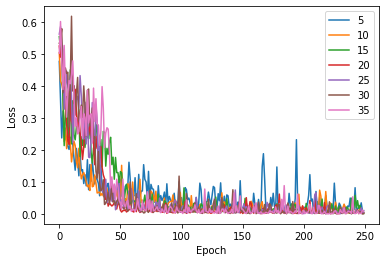

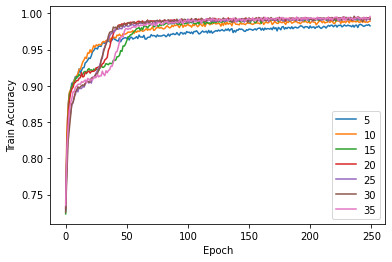

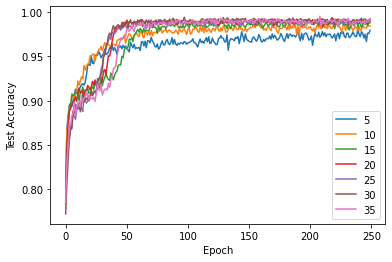

In [ ]:
num_epoch = 250
bs = 32
torch.manual_seed(42)
np.random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)
kernel_size = [5,10,15,20,25,30,35]

loss_function = nn.BCEWithLogitsLoss()

# Define the K-fold Cross Validator
kfold = KFold(n_splits=5, shuffle=True)

for fold, (train_ids, test_ids) in enumerate(kfold.split(dataset)):
  if fold==1:
    break

  for ker in kernel_size:
      print('--------------------------------')
      print(f'Kernel Size {ker}')
      print('--------------------------------')
      trainset = EEGDataset(all_data[train_ids],all_label[train_ids])
      testset = EEGDataset(all_data[test_ids],all_label[test_ids])
      
      trainloader = torch.utils.data.DataLoader(trainset,batch_size=bs)
      testloader = torch.utils.data.DataLoader(testset,batch_size=bs)

      network = ParallelConvolution(ker)
      network.to(device,dtype=torch.float)

      optimizer = torch.optim.Adam(network.parameters())
      
      lossHist = []
      testAccHist = []
      trainAccHist = []
      bestAcc = 0
      bestEpoch = 0
      for epoch in range(num_epoch):
          trainCorrect = 0
          trainTotal = 0
          testCorrect = 0
          testTotal = 0 

          for i, (data,label) in enumerate(trainloader):
              data = data.to(device,dtype=torch.float)
              label = label.to(device,dtype=torch.float)
              #print(label)
              # Zero the gradients
              optimizer.zero_grad()
              
              # Perform forward pass
              outputs = network(data)
              # Compute loss
              loss = loss_function(outputs, label)
              
              # Perform backward pass
              loss.backward()
              
              # Perform optimization
              optimizer.step()
              
              # # Print statistics
              # current_loss += loss.item()
              trainCorrect += np.sum(np.argmax(outputs.cpu().detach().numpy(),axis=1)==np.argmax(label.cpu().detach().numpy(),axis=1))
              trainTotal += len(outputs)
          
          for i, (data,label) in enumerate(testloader):
              data = data.to(device,dtype=torch.float)
              label = label.to(device,dtype=torch.float)
              
              # Perform forward pass
              outputs = network(data)

              #Caclulate statistics
              testCorrect += np.sum(np.argmax(outputs.cpu().detach().numpy(),axis=1)==np.argmax(label.cpu().detach().numpy(),axis=1))
              testTotal += len(outputs)
              #print(label)     
          
          if testCorrect/testTotal > bestAcc:
              # torch.save(network,'/content/drive/MyDrive/ISML Final Paper Files/ModelCheckpoint/'+'Fold'+str(fold)+'Epoch'+str(epoch))
              # bestAcc = testCorrect/testTotal
              torch.save(network.state_dict(),'/content/drive/MyDrive/ISML Final Paper Files/ModelCheckpoint/'+'Fold'+str(fold)+'Epoch'+str(epoch))
              bestAcc = testCorrect/testTotal
              bestEpoch = epoch
              #print(network.state_dict())
              #print(testCorrect)
          
          print('Epoch:',epoch,'Loss:', loss.item(), 'Train Accuracy:', trainCorrect/trainTotal, 'Test Accuracy:', testCorrect/testTotal)
          lossHist.append(loss)
          trainAccHist.append(trainCorrect/trainTotal)
          testAccHist.append(testCorrect/testTotal)

      plt.figure(1)
      plt.plot(np.arange(num_epoch),lossHist,label=str(ker))
      plt.xlabel('Epoch')
      plt.ylabel('Loss')
      plt.legend()
      plt.figure(2)
      plt.plot(np.arange(num_epoch),trainAccHist,label=str(ker))
      plt.xlabel('Epoch')
      plt.ylabel('Train Accuracy')
      plt.legend()
      plt.figure(3)
      plt.plot(np.arange(num_epoch),testAccHist,label=str(ker))
      plt.xlabel('Epoch')
      plt.ylabel('Test Accuracy')
      plt.legend()
      print('Best Accuracy:', bestAcc, 'at epoch:', bestEpoch)

--------------------------------
Kernel Size 40
--------------------------------
Epoch: 0 Loss: 0.31616899371147156 Train Accuracy: 0.74765625 Test Accuracy: 0.781640625
Epoch: 1 Loss: 0.3714679479598999 Train Accuracy: 0.82490234375 Test Accuracy: 0.825390625
Epoch: 2 Loss: 0.21421246230602264 Train Accuracy: 0.8560546875 Test Accuracy: 0.856640625
Epoch: 3 Loss: 0.20240485668182373 Train Accuracy: 0.8705078125 Test Accuracy: 0.875390625
Epoch: 4 Loss: 0.35880979895591736 Train Accuracy: 0.8837890625 Test Accuracy: 0.891796875
Epoch: 5 Loss: 0.16661152243614197 Train Accuracy: 0.88681640625 Test Accuracy: 0.88515625
Epoch: 6 Loss: 0.14536455273628235 Train Accuracy: 0.89501953125 Test Accuracy: 0.891796875
Epoch: 7 Loss: 0.10541903972625732 Train Accuracy: 0.89775390625 Test Accuracy: 0.89140625
Epoch: 8 Loss: 0.1161332055926323 Train Accuracy: 0.8984375 Test Accuracy: 0.902734375
Epoch: 9 Loss: 0.12418462336063385 Train Accuracy: 0.89892578125 Test Accuracy: 0.907421875
Epoch: 10 Los

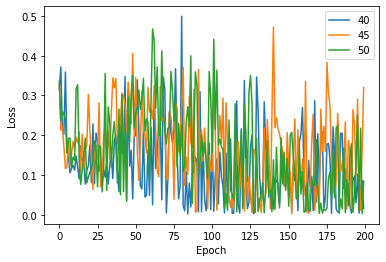

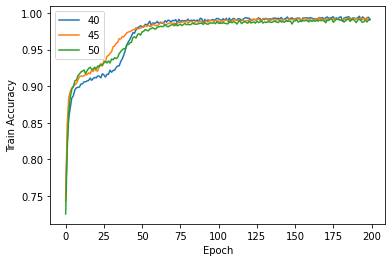

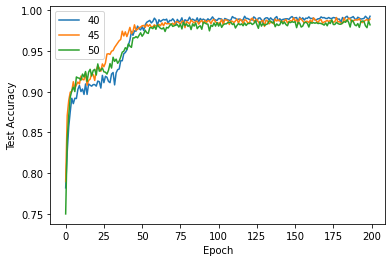

In [ ]:
num_epoch = 200
bs = 32
torch.manual_seed(42)
np.random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)
kernel_size = [40,45,50]

loss_function = nn.BCEWithLogitsLoss()

# Define the K-fold Cross Validator
kfold = KFold(n_splits=5, shuffle=True)

for fold, (train_ids, test_ids) in enumerate(kfold.split(dataset)):
  if fold==1:
    break

  for ker in kernel_size:
      print('--------------------------------')
      print(f'Kernel Size {ker}')
      print('--------------------------------')
      trainset = EEGDataset(all_data[train_ids],all_label[train_ids])
      testset = EEGDataset(all_data[test_ids],all_label[test_ids])
      
      trainloader = torch.utils.data.DataLoader(trainset,batch_size=bs)
      testloader = torch.utils.data.DataLoader(testset,batch_size=bs)

      network = ParallelConvolution(ker)
      network.to(device,dtype=torch.float)

      optimizer = torch.optim.Adam(network.parameters())
      
      lossHist = []
      testAccHist = []
      trainAccHist = []
      bestAcc = 0
      bestEpoch = 0
      for epoch in range(num_epoch):
          trainCorrect = 0
          trainTotal = 0
          testCorrect = 0
          testTotal = 0 

          for i, (data,label) in enumerate(trainloader):
              data = data.to(device,dtype=torch.float)
              label = label.to(device,dtype=torch.float)
              #print(label)
              # Zero the gradients
              optimizer.zero_grad()
              
              # Perform forward pass
              outputs = network(data)
              # Compute loss
              loss = loss_function(outputs, label)
              
              # Perform backward pass
              loss.backward()
              
              # Perform optimization
              optimizer.step()
              
              # # Print statistics
              # current_loss += loss.item()
              trainCorrect += np.sum(np.argmax(outputs.cpu().detach().numpy(),axis=1)==np.argmax(label.cpu().detach().numpy(),axis=1))
              trainTotal += len(outputs)
          
          for i, (data,label) in enumerate(testloader):
              data = data.to(device,dtype=torch.float)
              label = label.to(device,dtype=torch.float)
              
              # Perform forward pass
              outputs = network(data)

              #Caclulate statistics
              testCorrect += np.sum(np.argmax(outputs.cpu().detach().numpy(),axis=1)==np.argmax(label.cpu().detach().numpy(),axis=1))
              testTotal += len(outputs)
              #print(label)     
          
          if testCorrect/testTotal > bestAcc:
              # torch.save(network,'/content/drive/MyDrive/ISML Final Paper Files/ModelCheckpoint/'+'Fold'+str(fold)+'Epoch'+str(epoch))
              # bestAcc = testCorrect/testTotal
              torch.save(network.state_dict(),'/content/drive/MyDrive/ISML Final Paper Files/ModelCheckpoint/'+'Fold'+str(fold)+'Epoch'+str(epoch))
              bestAcc = testCorrect/testTotal
              bestEpoch = epoch
              #print(network.state_dict())
              #print(testCorrect)
          
          print('Epoch:',epoch,'Loss:', loss.item(), 'Train Accuracy:', trainCorrect/trainTotal, 'Test Accuracy:', testCorrect/testTotal)
          lossHist.append(loss)
          trainAccHist.append(trainCorrect/trainTotal)
          testAccHist.append(testCorrect/testTotal)

      plt.figure(1)
      plt.plot(np.arange(num_epoch),lossHist,label=str(ker))
      plt.xlabel('Epoch')
      plt.ylabel('Loss')
      plt.legend()
      plt.figure(2)
      plt.plot(np.arange(num_epoch),trainAccHist,label=str(ker))
      plt.xlabel('Epoch')
      plt.ylabel('Train Accuracy')
      plt.legend()
      plt.figure(3)
      plt.plot(np.arange(num_epoch),testAccHist,label=str(ker))
      plt.xlabel('Epoch')
      plt.ylabel('Test Accuracy')
      plt.legend()
      print('Best Accuracy:', bestAcc, 'at epoch:', bestEpoch)

--------------------------------
Kernel Size 31
--------------------------------
Epoch: 0 Loss: 0.26858967542648315 Train Accuracy: 0.75146484375 Test Accuracy: 0.771484375
Epoch: 1 Loss: 0.30656397342681885 Train Accuracy: 0.82626953125 Test Accuracy: 0.8265625
Epoch: 2 Loss: 0.4176451563835144 Train Accuracy: 0.85625 Test Accuracy: 0.8671875
Epoch: 3 Loss: 0.23091889917850494 Train Accuracy: 0.86669921875 Test Accuracy: 0.85703125
Epoch: 4 Loss: 0.19706760346889496 Train Accuracy: 0.87587890625 Test Accuracy: 0.86875
Epoch: 5 Loss: 0.23525606095790863 Train Accuracy: 0.88369140625 Test Accuracy: 0.875
Epoch: 6 Loss: 0.24231775104999542 Train Accuracy: 0.886328125 Test Accuracy: 0.878515625
Epoch: 7 Loss: 0.14551767706871033 Train Accuracy: 0.88876953125 Test Accuracy: 0.884765625
Epoch: 8 Loss: 0.10672082006931305 Train Accuracy: 0.8935546875 Test Accuracy: 0.8921875
Epoch: 9 Loss: 0.1551831066608429 Train Accuracy: 0.89501953125 Test Accuracy: 0.89609375
Epoch: 10 Loss: 0.1520107388

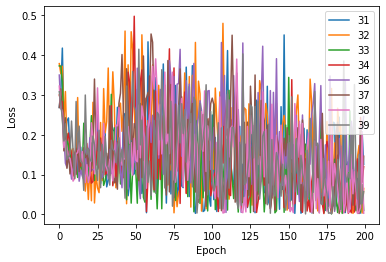

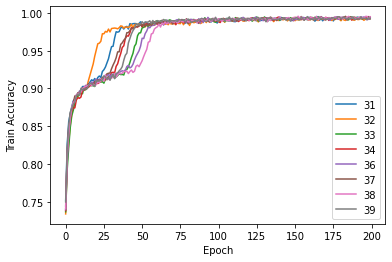

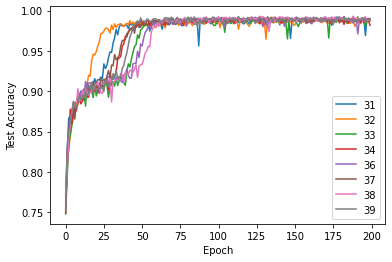

In [ ]:
num_epoch = 200
bs = 32
torch.manual_seed(42)
np.random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)
kernel_size = [31,32,33,34,36,37,38,39]

loss_function = nn.BCEWithLogitsLoss()

# Define the K-fold Cross Validator
kfold = KFold(n_splits=5, shuffle=True)

for fold, (train_ids, test_ids) in enumerate(kfold.split(dataset)):
  if fold==1:
    break

  for ker in kernel_size:
      print('--------------------------------')
      print(f'Kernel Size {ker}')
      print('--------------------------------')
      trainset = EEGDataset(all_data[train_ids],all_label[train_ids])
      testset = EEGDataset(all_data[test_ids],all_label[test_ids])
      
      trainloader = torch.utils.data.DataLoader(trainset,batch_size=bs)
      testloader = torch.utils.data.DataLoader(testset,batch_size=bs)

      network = ParallelConvolution(ker)
      network.to(device,dtype=torch.float)

      optimizer = torch.optim.Adam(network.parameters())
      
      lossHist = []
      testAccHist = []
      trainAccHist = []
      bestAcc = 0
      bestEpoch = 0
      for epoch in range(num_epoch):
          trainCorrect = 0
          trainTotal = 0
          testCorrect = 0
          testTotal = 0 

          for i, (data,label) in enumerate(trainloader):
              data = data.to(device,dtype=torch.float)
              label = label.to(device,dtype=torch.float)
              #print(label)
              # Zero the gradients
              optimizer.zero_grad()
              
              # Perform forward pass
              outputs = network(data)
              # Compute loss
              loss = loss_function(outputs, label)
              
              # Perform backward pass
              loss.backward()
              
              # Perform optimization
              optimizer.step()
              
              # # Print statistics
              # current_loss += loss.item()
              trainCorrect += np.sum(np.argmax(outputs.cpu().detach().numpy(),axis=1)==np.argmax(label.cpu().detach().numpy(),axis=1))
              trainTotal += len(outputs)
          
          for i, (data,label) in enumerate(testloader):
              data = data.to(device,dtype=torch.float)
              label = label.to(device,dtype=torch.float)
              
              # Perform forward pass
              outputs = network(data)

              #Caclulate statistics
              testCorrect += np.sum(np.argmax(outputs.cpu().detach().numpy(),axis=1)==np.argmax(label.cpu().detach().numpy(),axis=1))
              testTotal += len(outputs)
              #print(label)     
          
          if testCorrect/testTotal > bestAcc:
              # torch.save(network,'/content/drive/MyDrive/ISML Final Paper Files/ModelCheckpoint/'+'Fold'+str(fold)+'Epoch'+str(epoch))
              # bestAcc = testCorrect/testTotal
              torch.save(network.state_dict(),'/content/drive/MyDrive/ISML Final Paper Files/ModelCheckpoint/'+'Fold'+str(fold)+'Epoch'+str(epoch))
              bestAcc = testCorrect/testTotal
              bestEpoch = epoch
              #print(network.state_dict())
              #print(testCorrect)
          
          print('Epoch:',epoch,'Loss:', loss.item(), 'Train Accuracy:', trainCorrect/trainTotal, 'Test Accuracy:', testCorrect/testTotal)
          lossHist.append(loss)
          trainAccHist.append(trainCorrect/trainTotal)
          testAccHist.append(testCorrect/testTotal)

      plt.figure(1)
      plt.plot(np.arange(num_epoch),lossHist,label=str(ker))
      plt.xlabel('Epoch')
      plt.ylabel('Loss')
      plt.legend()
      plt.figure(2)
      plt.plot(np.arange(num_epoch),trainAccHist,label=str(ker))
      plt.xlabel('Epoch')
      plt.ylabel('Train Accuracy')
      plt.legend()
      plt.figure(3)
      plt.plot(np.arange(num_epoch),testAccHist,label=str(ker))
      plt.xlabel('Epoch')
      plt.ylabel('Test Accuracy')
      plt.legend()
      print('Best Accuracy:', bestAcc, 'at epoch:', bestEpoch)

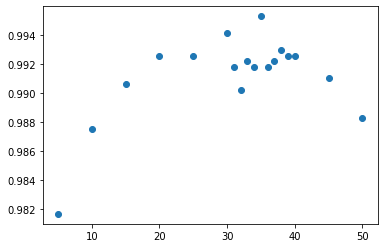

In [ ]:
kerSize = [5,10,15,20,25,30,35,40,45,50,31,32,33,34,36,37,38,39]
acc = [0.981640625,0.9875,0.990625,0.992578125,0.992578125,0.994140625,0.9953125,0.992578125,0.991015625,0.98828125,0.991796875,0.990234375,0.9921875,0.991796875,0.991796875,0.9921875,0.99296875,0.992578125]

plt.scatter(kerSize,acc)

In [ ]:
# --------------------------------
# 		Kernel Size 60
# 		--------------------------------
# 		Epoch: 0 Loss: 0.4441888928413391 Train Accuracy: 0.73447265625 Test Accuracy: 0.747265625
# 		Epoch: 1 Loss: 0.35847169160842896 Train Accuracy: 0.82001953125 Test Accuracy: 0.8140625
# 		Epoch: 2 Loss: 0.2886466383934021 Train Accuracy: 0.86181640625 Test Accuracy: 0.856640625
# 		Epoch: 3 Loss: 0.24210990965366364 Train Accuracy: 0.88388671875 Test Accuracy: 0.884375
# 		Epoch: 4 Loss: 0.21271014213562012 Train Accuracy: 0.9021484375 Test Accuracy: 0.902734375
# 		Epoch: 5 Loss: 0.2027304768562317 Train Accuracy: 0.91689453125 Test Accuracy: 0.916796875
# 		Epoch: 6 Loss: 0.19057783484458923 Train Accuracy: 0.926953125 Test Accuracy: 0.925390625
# 		Epoch: 7 Loss: 0.18045756220817566 Train Accuracy: 0.934375 Test Accuracy: 0.928125
# 		Epoch: 8 Loss: 0.1719743013381958 Train Accuracy: 0.93857421875 Test Accuracy: 0.9328125
# 		Epoch: 9 Loss: 0.15910150110721588 Train Accuracy: 0.94140625 Test Accuracy: 0.934765625
# 		Epoch: 10 Loss: 0.1520877480506897 Train Accuracy: 0.9453125 Test Accuracy: 0.938671875
# 		Epoch: 11 Loss: 0.14367659389972687 Train Accuracy: 0.946875 Test Accuracy: 0.94296875
# 		Epoch: 12 Loss: 0.13973785936832428 Train Accuracy: 0.94833984375 Test Accuracy: 0.943359375
# 		Epoch: 13 Loss: 0.13777866959571838 Train Accuracy: 0.94951171875 Test Accuracy: 0.944921875
# 		Epoch: 14 Loss: 0.134545236825943 Train Accuracy: 0.95126953125 Test Accuracy: 0.946875
# 		Epoch: 15 Loss: 0.1319509744644165 Train Accuracy: 0.9525390625 Test Accuracy: 0.946875
# 		Epoch: 16 Loss: 0.13013744354248047 Train Accuracy: 0.95439453125 Test Accuracy: 0.94609375
# 		Epoch: 17 Loss: 0.12831825017929077 Train Accuracy: 0.95556640625 Test Accuracy: 0.946875
# 		Epoch: 18 Loss: 0.1253359615802765 Train Accuracy: 0.95751953125 Test Accuracy: 0.9484375
# 		Epoch: 19 Loss: 0.12217424064874649 Train Accuracy: 0.958203125 Test Accuracy: 0.949609375
# 		Epoch: 20 Loss: 0.12009796500205994 Train Accuracy: 0.95869140625 Test Accuracy: 0.948828125
# 		Epoch: 21 Loss: 0.12089259922504425 Train Accuracy: 0.95908203125 Test Accuracy: 0.95078125
# 		Epoch: 22 Loss: 0.12046416103839874 Train Accuracy: 0.9595703125 Test Accuracy: 0.951171875
# 		Epoch: 23 Loss: 0.12122128158807755 Train Accuracy: 0.96025390625 Test Accuracy: 0.95078125
# 		Epoch: 24 Loss: 0.12227584421634674 Train Accuracy: 0.96123046875 Test Accuracy: 0.953125
# 		Epoch: 25 Loss: 0.12209804356098175 Train Accuracy: 0.96181640625 Test Accuracy: 0.953125
# 		Epoch: 26 Loss: 0.12016291916370392 Train Accuracy: 0.96259765625 Test Accuracy: 0.953125
# 		Epoch: 27 Loss: 0.1253737211227417 Train Accuracy: 0.96279296875 Test Accuracy: 0.953515625
# 		Epoch: 28 Loss: 0.12296194583177567 Train Accuracy: 0.9638671875 Test Accuracy: 0.9515625
# 		Epoch: 29 Loss: 0.12394610792398453 Train Accuracy: 0.96396484375 Test Accuracy: 0.9515625
# 		Epoch: 30 Loss: 0.12047509849071503 Train Accuracy: 0.9638671875 Test Accuracy: 0.953125
# 		Epoch: 31 Loss: 0.11648273468017578 Train Accuracy: 0.9646484375 Test Accuracy: 0.953125
# 		Epoch: 32 Loss: 0.10974632203578949 Train Accuracy: 0.965234375 Test Accuracy: 0.954296875
# 		Epoch: 33 Loss: 0.10416503995656967 Train Accuracy: 0.9662109375 Test Accuracy: 0.9546875
# 		Epoch: 34 Loss: 0.10304207354784012 Train Accuracy: 0.966015625 Test Accuracy: 0.954296875
# 		Epoch: 35 Loss: 0.10317111760377884 Train Accuracy: 0.967578125 Test Accuracy: 0.9546875
# 		Epoch: 36 Loss: 0.10023385286331177 Train Accuracy: 0.9673828125 Test Accuracy: 0.95625
# 		Epoch: 37 Loss: 0.09944921731948853 Train Accuracy: 0.96865234375 Test Accuracy: 0.955859375
# 		Epoch: 38 Loss: 0.09876806288957596 Train Accuracy: 0.96865234375 Test Accuracy: 0.95625
# 		Epoch: 39 Loss: 0.09454480558633804 Train Accuracy: 0.9689453125 Test Accuracy: 0.958203125
# 		Epoch: 40 Loss: 0.09158328175544739 Train Accuracy: 0.96943359375 Test Accuracy: 0.958984375
# 		Epoch: 41 Loss: 0.09428561478853226 Train Accuracy: 0.96943359375 Test Accuracy: 0.95859375
# 		Epoch: 42 Loss: 0.09048733860254288 Train Accuracy: 0.97021484375 Test Accuracy: 0.959765625
# 		Epoch: 43 Loss: 0.09018527716398239 Train Accuracy: 0.969921875 Test Accuracy: 0.959765625
# 		Epoch: 44 Loss: 0.08981017023324966 Train Accuracy: 0.97021484375 Test Accuracy: 0.959375
# 		Epoch: 45 Loss: 0.08666582405567169 Train Accuracy: 0.97060546875 Test Accuracy: 0.95859375
# 		Epoch: 46 Loss: 0.08767082542181015 Train Accuracy: 0.9708984375 Test Accuracy: 0.9578125
# 		Epoch: 47 Loss: 0.08813454955816269 Train Accuracy: 0.97080078125 Test Accuracy: 0.957421875
# 		Epoch: 48 Loss: 0.0895291194319725 Train Accuracy: 0.97158203125 Test Accuracy: 0.9578125
# 		Epoch: 49 Loss: 0.08810995519161224 Train Accuracy: 0.9720703125 Test Accuracy: 0.9578125
# 		Epoch: 50 Loss: 0.0905115157365799 Train Accuracy: 0.9728515625 Test Accuracy: 0.95859375
# 		Epoch: 51 Loss: 0.08583292365074158 Train Accuracy: 0.97265625 Test Accuracy: 0.957421875
# 		Epoch: 52 Loss: 0.08638079464435577 Train Accuracy: 0.9732421875 Test Accuracy: 0.95625
# 		Epoch: 53 Loss: 0.08642643690109253 Train Accuracy: 0.97314453125 Test Accuracy: 0.955078125
# 		Epoch: 54 Loss: 0.08311928808689117 Train Accuracy: 0.97412109375 Test Accuracy: 0.95625
# 		Epoch: 55 Loss: 0.08543098717927933 Train Accuracy: 0.97333984375 Test Accuracy: 0.955859375
# 		Epoch: 56 Loss: 0.078792043030262 Train Accuracy: 0.9736328125 Test Accuracy: 0.956640625
# 		Epoch: 57 Loss: 0.07579769194126129 Train Accuracy: 0.9740234375 Test Accuracy: 0.956640625
# 		Epoch: 58 Loss: 0.07493332773447037 Train Accuracy: 0.97275390625 Test Accuracy: 0.957421875
# 		Epoch: 59 Loss: 0.07369833439588547 Train Accuracy: 0.97373046875 Test Accuracy: 0.956640625
# 		Epoch: 60 Loss: 0.06396915763616562 Train Accuracy: 0.9734375 Test Accuracy: 0.95703125
# 		Epoch: 61 Loss: 0.06185561418533325 Train Accuracy: 0.973828125 Test Accuracy: 0.958203125
# 		Epoch: 62 Loss: 0.06617680937051773 Train Accuracy: 0.97421875 Test Accuracy: 0.959765625
# 		Epoch: 63 Loss: 0.05689398944377899 Train Accuracy: 0.97275390625 Test Accuracy: 0.95859375
# 		Epoch: 64 Loss: 0.06328380107879639 Train Accuracy: 0.97421875 Test Accuracy: 0.957421875
# 		Epoch: 65 Loss: 0.0515129379928112 Train Accuracy: 0.9736328125 Test Accuracy: 0.95546875
# 		Epoch: 66 Loss: 0.07119777053594589 Train Accuracy: 0.97421875 Test Accuracy: 0.9609375
# 		Epoch: 67 Loss: 0.048712342977523804 Train Accuracy: 0.9740234375 Test Accuracy: 0.961328125
# 		Epoch: 68 Loss: 0.05669781565666199 Train Accuracy: 0.9755859375 Test Accuracy: 0.962890625
# 		Epoch: 69 Loss: 0.0420469269156456 Train Accuracy: 0.976171875 Test Accuracy: 0.959375
# 		Epoch: 70 Loss: 0.040066562592983246 Train Accuracy: 0.9755859375 Test Accuracy: 0.963671875
# 		Epoch: 71 Loss: 0.04518066346645355 Train Accuracy: 0.97578125 Test Accuracy: 0.965234375
# 		Epoch: 72 Loss: 0.028414113447070122 Train Accuracy: 0.97666015625 Test Accuracy: 0.962890625
# 		Epoch: 73 Loss: 0.03090212494134903 Train Accuracy: 0.9771484375 Test Accuracy: 0.961328125
# 		Epoch: 74 Loss: 0.03396812453866005 Train Accuracy: 0.97822265625 Test Accuracy: 0.9625
# 		Epoch: 75 Loss: 0.02691160887479782 Train Accuracy: 0.978515625 Test Accuracy: 0.9640625
# 		Epoch: 76 Loss: 0.034691378474235535 Train Accuracy: 0.97919921875 Test Accuracy: 0.963671875
# 		Epoch: 77 Loss: 0.052588894963264465 Train Accuracy: 0.9796875 Test Accuracy: 0.960546875
# 		Epoch: 78 Loss: 0.028942640870809555 Train Accuracy: 0.97802734375 Test Accuracy: 0.9625
# 		Epoch: 79 Loss: 0.026757773011922836 Train Accuracy: 0.98056640625 Test Accuracy: 0.966796875
# 		Epoch: 80 Loss: 0.05003610625863075 Train Accuracy: 0.97919921875 Test Accuracy: 0.96171875
# 		Epoch: 81 Loss: 0.023080948740243912 Train Accuracy: 0.978125 Test Accuracy: 0.966796875
# 		Epoch: 82 Loss: 0.03637811541557312 Train Accuracy: 0.97939453125 Test Accuracy: 0.970703125
# 		Epoch: 83 Loss: 0.020207004621624947 Train Accuracy: 0.97802734375 Test Accuracy: 0.966015625
# 		Epoch: 84 Loss: 0.014576185494661331 Train Accuracy: 0.98037109375 Test Accuracy: 0.971484375
# 		Epoch: 85 Loss: 0.019566131755709648 Train Accuracy: 0.9810546875 Test Accuracy: 0.9640625
# 		Epoch: 86 Loss: 0.012030977755784988 Train Accuracy: 0.98037109375 Test Accuracy: 0.968359375
# 		Epoch: 87 Loss: 0.015334729105234146 Train Accuracy: 0.9822265625 Test Accuracy: 0.967578125
# 		Epoch: 88 Loss: 0.022793415933847427 Train Accuracy: 0.9798828125 Test Accuracy: 0.96953125
# 		Epoch: 89 Loss: 0.008916039951145649 Train Accuracy: 0.9779296875 Test Accuracy: 0.97109375
# 		Epoch: 90 Loss: 0.014838751405477524 Train Accuracy: 0.98203125 Test Accuracy: 0.971484375
# 		Epoch: 91 Loss: 0.019520550966262817 Train Accuracy: 0.980859375 Test Accuracy: 0.951953125
# 		Epoch: 92 Loss: 0.029598399996757507 Train Accuracy: 0.98037109375 Test Accuracy: 0.971875
# 		Epoch: 93 Loss: 0.03340156376361847 Train Accuracy: 0.97919921875 Test Accuracy: 0.96328125
# 		Epoch: 94 Loss: 0.01305265724658966 Train Accuracy: 0.9791015625 Test Accuracy: 0.969921875
# 		Epoch: 95 Loss: 0.016237426549196243 Train Accuracy: 0.9794921875 Test Accuracy: 0.970703125
# 		Epoch: 96 Loss: 0.013009555637836456 Train Accuracy: 0.98125 Test Accuracy: 0.965625
# 		Epoch: 97 Loss: 0.02084064483642578 Train Accuracy: 0.98134765625 Test Accuracy: 0.973828125
# 		Epoch: 98 Loss: 0.01208130270242691 Train Accuracy: 0.98173828125 Test Accuracy: 0.9703125
# 		Epoch: 99 Loss: 0.01828593946993351 Train Accuracy: 0.98203125 Test Accuracy: 0.964453125
# 		Epoch: 100 Loss: 0.021111540496349335 Train Accuracy: 0.98125 Test Accuracy: 0.955078125
# 		Epoch: 101 Loss: 0.02193332463502884 Train Accuracy: 0.979296875 Test Accuracy: 0.965625
# 		Epoch: 102 Loss: 0.01875489577651024 Train Accuracy: 0.97861328125 Test Accuracy: 0.95625
# 		Epoch: 103 Loss: 0.033985696732997894 Train Accuracy: 0.980859375 Test Accuracy: 0.969140625
# 		Epoch: 104 Loss: 0.01522812806069851 Train Accuracy: 0.9787109375 Test Accuracy: 0.961328125
# 		Epoch: 105 Loss: 0.015103315003216267 Train Accuracy: 0.9841796875 Test Accuracy: 0.969140625
# 		Epoch: 106 Loss: 0.030417686328291893 Train Accuracy: 0.98271484375 Test Accuracy: 0.973046875
# 		Epoch: 107 Loss: 0.008192399516701698 Train Accuracy: 0.9830078125 Test Accuracy: 0.96953125
# 		Epoch: 108 Loss: 0.09666106849908829 Train Accuracy: 0.98017578125 Test Accuracy: 0.97734375
# 		Epoch: 109 Loss: 0.009073534049093723 Train Accuracy: 0.9810546875 Test Accuracy: 0.974609375
# 		Epoch: 110 Loss: 0.006972683127969503 Train Accuracy: 0.98369140625 Test Accuracy: 0.97421875
# 		Epoch: 111 Loss: 0.14036132395267487 Train Accuracy: 0.981640625 Test Accuracy: 0.9578125
# 		Epoch: 112 Loss: 0.006285377778112888 Train Accuracy: 0.97900390625 Test Accuracy: 0.970703125
# 		Epoch: 113 Loss: 0.010933630168437958 Train Accuracy: 0.98291015625 Test Accuracy: 0.97265625
# 		Epoch: 114 Loss: 0.02133394032716751 Train Accuracy: 0.98427734375 Test Accuracy: 0.9625
# 		Epoch: 115 Loss: 0.009641384705901146 Train Accuracy: 0.98251953125 Test Accuracy: 0.948046875
# 		Epoch: 116 Loss: 0.027994289994239807 Train Accuracy: 0.98046875 Test Accuracy: 0.97265625
# 		Epoch: 117 Loss: 0.02019973285496235 Train Accuracy: 0.98359375 Test Accuracy: 0.975390625
# 		Epoch: 118 Loss: 0.04014826565980911 Train Accuracy: 0.98505859375 Test Accuracy: 0.973828125
# 		Epoch: 119 Loss: 0.006929307244718075 Train Accuracy: 0.98359375 Test Accuracy: 0.971484375
# 		Epoch: 120 Loss: 0.020776141434907913 Train Accuracy: 0.9837890625 Test Accuracy: 0.9734375
# 		Epoch: 121 Loss: 0.01247921772301197 Train Accuracy: 0.98447265625 Test Accuracy: 0.973828125
# 		Epoch: 122 Loss: 0.020605124533176422 Train Accuracy: 0.98046875 Test Accuracy: 0.965234375
# 		Epoch: 123 Loss: 0.02806026116013527 Train Accuracy: 0.98056640625 Test Accuracy: 0.974609375
# 		Epoch: 124 Loss: 0.02269098348915577 Train Accuracy: 0.98134765625 Test Accuracy: 0.977734375
# 		Epoch: 125 Loss: 0.011264952830970287 Train Accuracy: 0.9833984375 Test Accuracy: 0.975390625
# 		Epoch: 126 Loss: 0.037017177790403366 Train Accuracy: 0.984765625 Test Accuracy: 0.97734375
# 		Epoch: 127 Loss: 0.011527515947818756 Train Accuracy: 0.984765625 Test Accuracy: 0.977734375
# 		Epoch: 128 Loss: 0.011389493942260742 Train Accuracy: 0.98056640625 Test Accuracy: 0.97890625
# 		Epoch: 129 Loss: 0.007368742022663355 Train Accuracy: 0.9814453125 Test Accuracy: 0.9765625
# 		Epoch: 130 Loss: 0.007546636275947094 Train Accuracy: 0.9861328125 Test Accuracy: 0.97734375
# 		Epoch: 131 Loss: 0.11033458262681961 Train Accuracy: 0.98046875 Test Accuracy: 0.974609375
# 		Epoch: 132 Loss: 0.003976009786128998 Train Accuracy: 0.98310546875 Test Accuracy: 0.976953125
# 		Epoch: 133 Loss: 0.015940029174089432 Train Accuracy: 0.98173828125 Test Accuracy: 0.976953125
# 		Epoch: 134 Loss: 0.014944911003112793 Train Accuracy: 0.98349609375 Test Accuracy: 0.9765625
# 		Epoch: 135 Loss: 0.007919680327177048 Train Accuracy: 0.98623046875 Test Accuracy: 0.9828125
# 		Epoch: 136 Loss: 0.023165391758084297 Train Accuracy: 0.98515625 Test Accuracy: 0.98203125
# 		Epoch: 137 Loss: 0.0040400526486337185 Train Accuracy: 0.9826171875 Test Accuracy: 0.975
# 		Epoch: 138 Loss: 0.01647748425602913 Train Accuracy: 0.9861328125 Test Accuracy: 0.97734375
# 		Epoch: 139 Loss: 0.034582529217004776 Train Accuracy: 0.9826171875 Test Accuracy: 0.978515625
# 		Epoch: 140 Loss: 0.05418006330728531 Train Accuracy: 0.98486328125 Test Accuracy: 0.978125
# 		Epoch: 141 Loss: 0.006098723504692316 Train Accuracy: 0.98779296875 Test Accuracy: 0.979296875
# 		Epoch: 142 Loss: 0.015789315104484558 Train Accuracy: 0.987890625 Test Accuracy: 0.971484375
# 		Epoch: 143 Loss: 0.012256253510713577 Train Accuracy: 0.983203125 Test Accuracy: 0.980078125
# 		Epoch: 144 Loss: 0.005017009563744068 Train Accuracy: 0.98486328125 Test Accuracy: 0.9828125
# 		Epoch: 145 Loss: 0.008504287339746952 Train Accuracy: 0.9859375 Test Accuracy: 0.98203125
# 		Epoch: 146 Loss: 0.03397626429796219 Train Accuracy: 0.98720703125 Test Accuracy: 0.97578125
# 		Epoch: 147 Loss: 0.0013076900504529476 Train Accuracy: 0.988671875 Test Accuracy: 0.978515625
# 		Epoch: 148 Loss: 0.00808179285377264 Train Accuracy: 0.98173828125 Test Accuracy: 0.977734375
# 		Epoch: 149 Loss: 0.035479407757520676 Train Accuracy: 0.98486328125 Test Accuracy: 0.9765625
# 		Epoch: 150 Loss: 0.02873414382338524 Train Accuracy: 0.9853515625 Test Accuracy: 0.980859375
# 		Epoch: 151 Loss: 0.003108241595327854 Train Accuracy: 0.98779296875 Test Accuracy: 0.98125
# 		Epoch: 152 Loss: 0.005146815907210112 Train Accuracy: 0.9873046875 Test Accuracy: 0.980859375
# 		Epoch: 153 Loss: 0.027458567172288895 Train Accuracy: 0.98681640625 Test Accuracy: 0.9796875
# 		Epoch: 154 Loss: 0.06148596480488777 Train Accuracy: 0.98369140625 Test Accuracy: 0.98046875
# 		Epoch: 155 Loss: 0.03697239235043526 Train Accuracy: 0.985546875 Test Accuracy: 0.984375
# 		Epoch: 156 Loss: 0.00952912587672472 Train Accuracy: 0.987109375 Test Accuracy: 0.9796875
# 		Epoch: 157 Loss: 0.07955072075128555 Train Accuracy: 0.98515625 Test Accuracy: 0.98203125
# 		Epoch: 158 Loss: 0.031759314239025116 Train Accuracy: 0.9876953125 Test Accuracy: 0.9765625
# 		Epoch: 159 Loss: 0.0049145095981657505 Train Accuracy: 0.9857421875 Test Accuracy: 0.979296875
# 		Epoch: 160 Loss: 0.01305113360285759 Train Accuracy: 0.98525390625 Test Accuracy: 0.978125
# 		Epoch: 161 Loss: 0.007794969715178013 Train Accuracy: 0.98525390625 Test Accuracy: 0.975390625
# 		Epoch: 162 Loss: 0.00557049922645092 Train Accuracy: 0.987890625 Test Accuracy: 0.974609375
# 		Epoch: 163 Loss: 0.016794478520751 Train Accuracy: 0.986328125 Test Accuracy: 0.983984375
# 		Epoch: 164 Loss: 0.03920312970876694 Train Accuracy: 0.98583984375 Test Accuracy: 0.980859375
# 		Epoch: 165 Loss: 0.060419756919145584 Train Accuracy: 0.98408203125 Test Accuracy: 0.97890625
# 		Epoch: 166 Loss: 0.06325903534889221 Train Accuracy: 0.98681640625 Test Accuracy: 0.9796875
# 		Epoch: 167 Loss: 0.01912832446396351 Train Accuracy: 0.9853515625 Test Accuracy: 0.98203125
# 		Epoch: 168 Loss: 0.006887056864798069 Train Accuracy: 0.9869140625 Test Accuracy: 0.97421875
# 		Epoch: 169 Loss: 0.001369473640806973 Train Accuracy: 0.9865234375 Test Accuracy: 0.9796875
# 		Epoch: 170 Loss: 0.008398381993174553 Train Accuracy: 0.9865234375 Test Accuracy: 0.98046875
# 		Epoch: 171 Loss: 0.0024134297855198383 Train Accuracy: 0.98779296875 Test Accuracy: 0.98359375
# 		Epoch: 172 Loss: 0.0657348781824112 Train Accuracy: 0.98271484375 Test Accuracy: 0.975390625
# 		Epoch: 173 Loss: 0.001408568350598216 Train Accuracy: 0.98662109375 Test Accuracy: 0.984765625
# 		Epoch: 174 Loss: 0.002914625220000744 Train Accuracy: 0.9892578125 Test Accuracy: 0.9859375
# 		Epoch: 175 Loss: 0.05233177915215492 Train Accuracy: 0.989453125 Test Accuracy: 0.984375
# 		Epoch: 176 Loss: 0.01883642002940178 Train Accuracy: 0.98310546875 Test Accuracy: 0.975
# 		Epoch: 177 Loss: 0.0058436319231987 Train Accuracy: 0.9798828125 Test Accuracy: 0.981640625
# 		Epoch: 178 Loss: 0.019066577777266502 Train Accuracy: 0.98837890625 Test Accuracy: 0.98125
# 		Epoch: 179 Loss: 0.04388190805912018 Train Accuracy: 0.98935546875 Test Accuracy: 0.975390625
# 		Epoch: 180 Loss: 0.002617341000586748 Train Accuracy: 0.98974609375 Test Accuracy: 0.983203125
# 		Epoch: 181 Loss: 0.0735277608036995 Train Accuracy: 0.98505859375 Test Accuracy: 0.981640625
# 		Epoch: 182 Loss: 0.009361973963677883 Train Accuracy: 0.98466796875 Test Accuracy: 0.98515625
# 		Epoch: 183 Loss: 0.008120236918330193 Train Accuracy: 0.9869140625 Test Accuracy: 0.972265625
# 		Epoch: 184 Loss: 0.004006882198154926 Train Accuracy: 0.98642578125 Test Accuracy: 0.978515625
# 		Epoch: 185 Loss: 0.0056018345057964325 Train Accuracy: 0.99130859375 Test Accuracy: 0.987109375
# 		Epoch: 186 Loss: 0.059937264770269394 Train Accuracy: 0.98798828125 Test Accuracy: 0.98125
# 		Epoch: 187 Loss: 0.004598341416567564 Train Accuracy: 0.98603515625 Test Accuracy: 0.98515625
# 		Epoch: 188 Loss: 0.026394635438919067 Train Accuracy: 0.9892578125 Test Accuracy: 0.984375
# 		Epoch: 189 Loss: 0.04155345261096954 Train Accuracy: 0.9857421875 Test Accuracy: 0.97890625
# 		Epoch: 190 Loss: 0.0018707405542954803 Train Accuracy: 0.99072265625 Test Accuracy: 0.984375
# 		Epoch: 191 Loss: 0.029003743082284927 Train Accuracy: 0.98525390625 Test Accuracy: 0.97890625
# 		Epoch: 192 Loss: 0.008105689659714699 Train Accuracy: 0.98583984375 Test Accuracy: 0.981640625
# 		Epoch: 193 Loss: 0.003750106319785118 Train Accuracy: 0.990625 Test Accuracy: 0.98125
# 		Epoch: 194 Loss: 0.01197303831577301 Train Accuracy: 0.9912109375 Test Accuracy: 0.98125
# 		Epoch: 195 Loss: 0.004207213409245014 Train Accuracy: 0.9890625 Test Accuracy: 0.97734375
# 		Epoch: 196 Loss: 0.2271302044391632 Train Accuracy: 0.9837890625 Test Accuracy: 0.97421875
# 		Epoch: 197 Loss: 0.018550684675574303 Train Accuracy: 0.988671875 Test Accuracy: 0.96484375
# 		Epoch: 198 Loss: 0.04548531025648117 Train Accuracy: 0.9865234375 Test Accuracy: 0.970703125
# 		Epoch: 199 Loss: 0.006565561518073082 Train Accuracy: 0.9869140625 Test Accuracy: 0.975
# 		Epoch: 200 Loss: 0.0573643334209919 Train Accuracy: 0.9873046875 Test Accuracy: 0.9765625
# 		Epoch: 201 Loss: 0.018868733197450638 Train Accuracy: 0.9884765625 Test Accuracy: 0.968359375
# 		Epoch: 202 Loss: 0.0021286476403474808 Train Accuracy: 0.98974609375 Test Accuracy: 0.980859375
# 		Epoch: 203 Loss: 0.004570760298520327 Train Accuracy: 0.99228515625 Test Accuracy: 0.979296875
# 		Epoch: 204 Loss: 0.07534845173358917 Train Accuracy: 0.98603515625 Test Accuracy: 0.964453125
# 		Epoch: 205 Loss: 0.013625886291265488 Train Accuracy: 0.98369140625 Test Accuracy: 0.96640625
# 		Epoch: 206 Loss: 0.03431425616145134 Train Accuracy: 0.98564453125 Test Accuracy: 0.97421875
# 		Epoch: 207 Loss: 0.03316272422671318 Train Accuracy: 0.9853515625 Test Accuracy: 0.9734375
# 		Epoch: 208 Loss: 0.05915002152323723 Train Accuracy: 0.9904296875 Test Accuracy: 0.960546875
# 		Epoch: 209 Loss: 0.1064877063035965 Train Accuracy: 0.98818359375 Test Accuracy: 0.9671875
# 		Epoch: 210 Loss: 0.01703239604830742 Train Accuracy: 0.990234375 Test Accuracy: 0.976953125
# 		Epoch: 211 Loss: 0.018758686259388924 Train Accuracy: 0.9896484375 Test Accuracy: 0.976953125
# 		Epoch: 212 Loss: 0.01914701797068119 Train Accuracy: 0.98525390625 Test Accuracy: 0.981640625
# 		Epoch: 213 Loss: 0.008280925452709198 Train Accuracy: 0.9900390625 Test Accuracy: 0.973828125
# 		Epoch: 214 Loss: 0.06997862458229065 Train Accuracy: 0.98837890625 Test Accuracy: 0.971875
# 		Epoch: 215 Loss: 0.005496114492416382 Train Accuracy: 0.98935546875 Test Accuracy: 0.9734375
# 		Epoch: 216 Loss: 0.003847541520372033 Train Accuracy: 0.98251953125 Test Accuracy: 0.98046875
# 		Epoch: 217 Loss: 0.0646781474351883 Train Accuracy: 0.9859375 Test Accuracy: 0.971875
# 		Epoch: 218 Loss: 0.044427692890167236 Train Accuracy: 0.98916015625 Test Accuracy: 0.97265625
# 		Epoch: 219 Loss: 0.11336593329906464 Train Accuracy: 0.99052734375 Test Accuracy: 0.96875
# 		Epoch: 220 Loss: 0.010248555801808834 Train Accuracy: 0.99033203125 Test Accuracy: 0.976953125
# 		Epoch: 221 Loss: 0.031357862055301666 Train Accuracy: 0.98935546875 Test Accuracy: 0.97109375
# 		Epoch: 222 Loss: 0.024615276604890823 Train Accuracy: 0.98623046875 Test Accuracy: 0.968359375
# 		Epoch: 223 Loss: 0.015077624469995499 Train Accuracy: 0.9876953125 Test Accuracy: 0.972265625
# 		Epoch: 224 Loss: 0.008271424099802971 Train Accuracy: 0.9900390625 Test Accuracy: 0.970703125
# 		Epoch: 225 Loss: 0.01865239068865776 Train Accuracy: 0.98798828125 Test Accuracy: 0.969140625
# 		Epoch: 226 Loss: 0.013072682544589043 Train Accuracy: 0.99052734375 Test Accuracy: 0.976953125
# 		Epoch: 227 Loss: 0.06480201333761215 Train Accuracy: 0.9900390625 Test Accuracy: 0.98046875
# 		Epoch: 228 Loss: 0.031197339296340942 Train Accuracy: 0.9892578125 Test Accuracy: 0.971484375
# 		Epoch: 229 Loss: 0.006455805152654648 Train Accuracy: 0.99248046875 Test Accuracy: 0.96640625
# 		Epoch: 230 Loss: 0.10157956182956696 Train Accuracy: 0.98857421875 Test Accuracy: 0.96875
# 		Epoch: 231 Loss: 0.03003501147031784 Train Accuracy: 0.98916015625 Test Accuracy: 0.97109375
# 		Epoch: 232 Loss: 0.03790374845266342 Train Accuracy: 0.9876953125 Test Accuracy: 0.96953125
# 		Epoch: 233 Loss: 0.03572036325931549 Train Accuracy: 0.98779296875 Test Accuracy: 0.9609375
# 		Epoch: 234 Loss: 0.027612611651420593 Train Accuracy: 0.98701171875 Test Accuracy: 0.96796875
# 		Epoch: 235 Loss: 0.01844857633113861 Train Accuracy: 0.989453125 Test Accuracy: 0.973828125
# 		Epoch: 236 Loss: 0.007788566872477531 Train Accuracy: 0.98896484375 Test Accuracy: 0.972265625
# 		Epoch: 237 Loss: 0.02019060030579567 Train Accuracy: 0.99013671875 Test Accuracy: 0.965625
# 		Epoch: 238 Loss: 0.07625070214271545 Train Accuracy: 0.9912109375 Test Accuracy: 0.96484375
# 		Epoch: 239 Loss: 0.0021064728498458862 Train Accuracy: 0.9916015625 Test Accuracy: 0.980078125
# 		Epoch: 240 Loss: 0.045715294778347015 Train Accuracy: 0.98779296875 Test Accuracy: 0.967578125
# 		Epoch: 241 Loss: 0.00027169499662704766 Train Accuracy: 0.991015625 Test Accuracy: 0.9796875
# 		Epoch: 242 Loss: 0.006507882848381996 Train Accuracy: 0.98837890625 Test Accuracy: 0.969921875
# 		Epoch: 243 Loss: 0.008948738686740398 Train Accuracy: 0.99072265625 Test Accuracy: 0.97109375
# 		Epoch: 244 Loss: 0.01555761881172657 Train Accuracy: 0.9904296875 Test Accuracy: 0.976953125
# 		Epoch: 245 Loss: 0.01257520541548729 Train Accuracy: 0.98505859375 Test Accuracy: 0.97109375
# 		Epoch: 246 Loss: 0.00531071936711669 Train Accuracy: 0.990234375 Test Accuracy: 0.971875
# 		Epoch: 247 Loss: 0.0013416004367172718 Train Accuracy: 0.9919921875 Test Accuracy: 0.975390625
# 		Epoch: 248 Loss: 0.03746628388762474 Train Accuracy: 0.98974609375 Test Accuracy: 0.966015625
# 		Epoch: 249 Loss: 0.005663794465363026 Train Accuracy: 0.9935546875 Test Accuracy: 0.976171875
# 		Epoch: 250 Loss: 0.020042384043335915 Train Accuracy: 0.98681640625 Test Accuracy: 0.97109375
# 		Epoch: 251 Loss: 0.007798294071108103 Train Accuracy: 0.99208984375 Test Accuracy: 0.972265625
# 		Epoch: 252 Loss: 0.03870371729135513 Train Accuracy: 0.9931640625 Test Accuracy: 0.96640625
# 		Epoch: 253 Loss: 0.004086318891495466 Train Accuracy: 0.9921875 Test Accuracy: 0.97890625
# 		Epoch: 254 Loss: 0.05265708640217781 Train Accuracy: 0.9880859375 Test Accuracy: 0.98046875
# 		Epoch: 255 Loss: 0.08286406099796295 Train Accuracy: 0.985546875 Test Accuracy: 0.96796875
# 		Epoch: 256 Loss: 0.007726097013801336 Train Accuracy: 0.98916015625 Test Accuracy: 0.970703125
# 		Epoch: 257 Loss: 0.03638143464922905 Train Accuracy: 0.98896484375 Test Accuracy: 0.959765625
# 		Epoch: 258 Loss: 0.06348545849323273 Train Accuracy: 0.98818359375 Test Accuracy: 0.9515625
# 		Epoch: 259 Loss: 0.005072371102869511 Train Accuracy: 0.99150390625 Test Accuracy: 0.969140625
# 		Epoch: 260 Loss: 0.10825495421886444 Train Accuracy: 0.98740234375 Test Accuracy: 0.9640625
# 		Epoch: 261 Loss: 0.009674984961748123 Train Accuracy: 0.9900390625 Test Accuracy: 0.970703125
# 		Epoch: 262 Loss: 0.0008503131102770567 Train Accuracy: 0.99189453125 Test Accuracy: 0.9734375
# 		Epoch: 263 Loss: 0.027358047664165497 Train Accuracy: 0.98994140625 Test Accuracy: 0.97109375
# 		Epoch: 264 Loss: 0.015859492123126984 Train Accuracy: 0.99033203125 Test Accuracy: 0.9703125
# 		Epoch: 265 Loss: 0.0007414449937641621 Train Accuracy: 0.99130859375 Test Accuracy: 0.97265625
# 		Epoch: 266 Loss: 0.008536634966731071 Train Accuracy: 0.992578125 Test Accuracy: 0.970703125
# 		Epoch: 267 Loss: 0.001770827337168157 Train Accuracy: 0.98837890625 Test Accuracy: 0.978125
# 		Epoch: 268 Loss: 0.001683527254499495 Train Accuracy: 0.98720703125 Test Accuracy: 0.976171875
# 		Epoch: 269 Loss: 0.015969574451446533 Train Accuracy: 0.99091796875 Test Accuracy: 0.965625
# 		Epoch: 270 Loss: 0.007446958217769861 Train Accuracy: 0.99375 Test Accuracy: 0.97265625
# 		Epoch: 271 Loss: 0.03738149255514145 Train Accuracy: 0.99013671875 Test Accuracy: 0.98125
# 		Epoch: 272 Loss: 0.026696112006902695 Train Accuracy: 0.9904296875 Test Accuracy: 0.97578125
# 		Epoch: 273 Loss: 0.002613855991512537 Train Accuracy: 0.99296875 Test Accuracy: 0.971484375
# 		Epoch: 274 Loss: 0.04848983511328697 Train Accuracy: 0.98916015625 Test Accuracy: 0.97265625
# 		Epoch: 275 Loss: 0.005284457933157682 Train Accuracy: 0.9923828125 Test Accuracy: 0.958984375
# 		Epoch: 276 Loss: 0.010638924315571785 Train Accuracy: 0.98857421875 Test Accuracy: 0.974609375
# 		Epoch: 277 Loss: 0.010004406794905663 Train Accuracy: 0.99306640625 Test Accuracy: 0.98359375
# 		Epoch: 278 Loss: 0.0003662468516267836 Train Accuracy: 0.987890625 Test Accuracy: 0.986328125
# 		Epoch: 279 Loss: 0.008236505091190338 Train Accuracy: 0.98740234375 Test Accuracy: 0.980078125
# 		Epoch: 280 Loss: 0.003762446343898773 Train Accuracy: 0.99130859375 Test Accuracy: 0.975
# 		Epoch: 281 Loss: 0.09858692437410355 Train Accuracy: 0.990625 Test Accuracy: 0.970703125
# 		Epoch: 282 Loss: 0.00519855972379446 Train Accuracy: 0.98994140625 Test Accuracy: 0.967578125
# 		Epoch: 283 Loss: 0.009764621034264565 Train Accuracy: 0.9939453125 Test Accuracy: 0.969140625
# 		Epoch: 284 Loss: 0.0031852738466113806 Train Accuracy: 0.99208984375 Test Accuracy: 0.973046875
# 		Epoch: 285 Loss: 0.01572803035378456 Train Accuracy: 0.99072265625 Test Accuracy: 0.974609375
# 		Epoch: 286 Loss: 0.008932934142649174 Train Accuracy: 0.991015625 Test Accuracy: 0.978515625
# 		Epoch: 287 Loss: 0.06311419606208801 Train Accuracy: 0.99296875 Test Accuracy: 0.965234375
# 		Epoch: 288 Loss: 0.014516850933432579 Train Accuracy: 0.98916015625 Test Accuracy: 0.97109375
# 		Epoch: 289 Loss: 0.002369549358263612 Train Accuracy: 0.9890625 Test Accuracy: 0.971875
# 		Epoch: 290 Loss: 0.01448114588856697 Train Accuracy: 0.99228515625 Test Accuracy: 0.9734375
# 		Epoch: 291 Loss: 0.03791198879480362 Train Accuracy: 0.9931640625 Test Accuracy: 0.962890625
# 		Epoch: 292 Loss: 0.004492609761655331 Train Accuracy: 0.99384765625 Test Accuracy: 0.97421875
# 		Epoch: 293 Loss: 0.002602460328489542 Train Accuracy: 0.99501953125 Test Accuracy: 0.967578125
# 		Epoch: 294 Loss: 0.005568391643464565 Train Accuracy: 0.99091796875 Test Accuracy: 0.975390625
# 		Epoch: 295 Loss: 0.0052557289600372314 Train Accuracy: 0.98544921875 Test Accuracy: 0.98515625
# 		Epoch: 296 Loss: 0.07283328473567963 Train Accuracy: 0.99189453125 Test Accuracy: 0.977734375
# 		Epoch: 297 Loss: 0.00044090868323110044 Train Accuracy: 0.9943359375 Test Accuracy: 0.977734375
# 		Epoch: 298 Loss: 0.0034652138128876686 Train Accuracy: 0.99306640625 Test Accuracy: 0.966015625
# 		Epoch: 299 Loss: 0.07292434573173523 Train Accuracy: 0.987109375 Test Accuracy: 0.974609375
# 		Epoch: 300 Loss: 0.013558851554989815 Train Accuracy: 0.99208984375 Test Accuracy: 0.97421875
# 		Epoch: 301 Loss: 0.006425502244383097 Train Accuracy: 0.992578125 Test Accuracy: 0.968359375
# 		Epoch: 302 Loss: 0.09006635844707489 Train Accuracy: 0.989453125 Test Accuracy: 0.971875
# 		Epoch: 303 Loss: 0.0029488899745047092 Train Accuracy: 0.99306640625 Test Accuracy: 0.97734375
# 		Epoch: 304 Loss: 0.004259072244167328 Train Accuracy: 0.99443359375 Test Accuracy: 0.9703125
# 		Epoch: 305 Loss: 0.003611623775213957 Train Accuracy: 0.99013671875 Test Accuracy: 0.97734375
# 		Epoch: 306 Loss: 0.015825174748897552 Train Accuracy: 0.9904296875 Test Accuracy: 0.97890625
# 		Epoch: 307 Loss: 0.0066247908398509026 Train Accuracy: 0.99013671875 Test Accuracy: 0.9640625
# 		Epoch: 308 Loss: 0.10164421796798706 Train Accuracy: 0.99208984375 Test Accuracy: 0.958984375
# 		Epoch: 309 Loss: 0.00109996204264462 Train Accuracy: 0.99091796875 Test Accuracy: 0.975
# 		Epoch: 310 Loss: 0.0024447457399219275 Train Accuracy: 0.99306640625 Test Accuracy: 0.969921875
# 		Epoch: 311 Loss: 0.005619770847260952 Train Accuracy: 0.9927734375 Test Accuracy: 0.98046875
# 		Epoch: 312 Loss: 0.021215060725808144 Train Accuracy: 0.9927734375 Test Accuracy: 0.976953125
# 		Epoch: 313 Loss: 0.017002785578370094 Train Accuracy: 0.99111328125 Test Accuracy: 0.98359375
# 		Epoch: 314 Loss: 0.0023099579848349094 Train Accuracy: 0.9890625 Test Accuracy: 0.983984375
# 		Epoch: 315 Loss: 0.03297993913292885 Train Accuracy: 0.9919921875 Test Accuracy: 0.978125
# 		Epoch: 316 Loss: 0.02177136391401291 Train Accuracy: 0.99326171875 Test Accuracy: 0.964453125
# 		Epoch: 317 Loss: 0.007351589854806662 Train Accuracy: 0.99287109375 Test Accuracy: 0.961328125
# 		Epoch: 318 Loss: 0.003504646010696888 Train Accuracy: 0.9935546875 Test Accuracy: 0.981640625
# 		Epoch: 319 Loss: 0.016298506408929825 Train Accuracy: 0.99130859375 Test Accuracy: 0.96953125
# 		Epoch: 320 Loss: 0.016469158232212067 Train Accuracy: 0.99169921875 Test Accuracy: 0.97890625
# 		Epoch: 321 Loss: 0.004385366570204496 Train Accuracy: 0.99208984375 Test Accuracy: 0.97265625
# 		Epoch: 322 Loss: 0.011145593598484993 Train Accuracy: 0.9865234375 Test Accuracy: 0.965625
# 		Epoch: 323 Loss: 0.023251881822943687 Train Accuracy: 0.99228515625 Test Accuracy: 0.9703125
# 		Epoch: 324 Loss: 0.008812147192656994 Train Accuracy: 0.99189453125 Test Accuracy: 0.97578125
# 		Epoch: 325 Loss: 0.016921084374189377 Train Accuracy: 0.9947265625 Test Accuracy: 0.97265625
# 		Epoch: 326 Loss: 0.002194999950006604 Train Accuracy: 0.99375 Test Accuracy: 0.977734375
# 		Epoch: 327 Loss: 0.004463633988052607 Train Accuracy: 0.99130859375 Test Accuracy: 0.965234375
# 		Epoch: 328 Loss: 0.002095191739499569 Train Accuracy: 0.9919921875 Test Accuracy: 0.98125
# 		Epoch: 329 Loss: 0.0002243968629045412 Train Accuracy: 0.99306640625 Test Accuracy: 0.98828125
# 		Epoch: 330 Loss: 0.0656525194644928 Train Accuracy: 0.99130859375 Test Accuracy: 0.97890625
# 		Epoch: 331 Loss: 0.004344464745372534 Train Accuracy: 0.9921875 Test Accuracy: 0.98359375
# 		Epoch: 332 Loss: 0.003022474003955722 Train Accuracy: 0.99521484375 Test Accuracy: 0.977734375
# 		Epoch: 333 Loss: 0.011267612688243389 Train Accuracy: 0.9931640625 Test Accuracy: 0.978515625
# 		Epoch: 334 Loss: 0.020426146686077118 Train Accuracy: 0.99404296875 Test Accuracy: 0.98203125
# 		Epoch: 335 Loss: 0.007633386179804802 Train Accuracy: 0.9943359375 Test Accuracy: 0.974609375
# 		Epoch: 336 Loss: 0.015214722603559494 Train Accuracy: 0.99384765625 Test Accuracy: 0.977734375
# 		Epoch: 337 Loss: 0.08554621040821075 Train Accuracy: 0.991796875 Test Accuracy: 0.97421875
# 		Epoch: 338 Loss: 0.00013639616372529417 Train Accuracy: 0.99208984375 Test Accuracy: 0.98203125
# 		Epoch: 339 Loss: 0.012436073273420334 Train Accuracy: 0.9931640625 Test Accuracy: 0.974609375
# 		Epoch: 340 Loss: 0.004027514718472958 Train Accuracy: 0.990625 Test Accuracy: 0.984375
# 		Epoch: 341 Loss: 0.0021826140582561493 Train Accuracy: 0.9916015625 Test Accuracy: 0.9796875
# 		Epoch: 342 Loss: 0.01445858832448721 Train Accuracy: 0.99248046875 Test Accuracy: 0.977734375
# 		Epoch: 343 Loss: 0.0015104291960597038 Train Accuracy: 0.994140625 Test Accuracy: 0.98515625
# 		Epoch: 344 Loss: 0.024601392447948456 Train Accuracy: 0.99443359375 Test Accuracy: 0.976171875
# 		Epoch: 345 Loss: 0.0016493148868903518 Train Accuracy: 0.99462890625 Test Accuracy: 0.981640625
# 		Epoch: 346 Loss: 0.0024239360354840755 Train Accuracy: 0.9943359375 Test Accuracy: 0.97578125
# 		Epoch: 347 Loss: 0.023180952295660973 Train Accuracy: 0.98671875 Test Accuracy: 0.9796875
# 		Epoch: 348 Loss: 0.004123724065721035 Train Accuracy: 0.99560546875 Test Accuracy: 0.98359375
# 		Epoch: 349 Loss: 0.10445133596658707 Train Accuracy: 0.9958984375 Test Accuracy: 0.984375
# 		Epoch: 350 Loss: 0.0021551630925387144 Train Accuracy: 0.993359375 Test Accuracy: 0.990234375
# 		Epoch: 351 Loss: 0.01954638585448265 Train Accuracy: 0.98984375 Test Accuracy: 0.985546875
# 		Epoch: 352 Loss: 0.002202169969677925 Train Accuracy: 0.98984375 Test Accuracy: 0.97890625
# 		Epoch: 353 Loss: 0.002781093353405595 Train Accuracy: 0.99365234375 Test Accuracy: 0.98828125
# 		Epoch: 354 Loss: 0.0009927530772984028 Train Accuracy: 0.99619140625 Test Accuracy: 0.988671875
# 		Epoch: 355 Loss: 0.0035823227372020483 Train Accuracy: 0.9955078125 Test Accuracy: 0.979296875
# 		Epoch: 356 Loss: 0.0027602158952504396 Train Accuracy: 0.9927734375 Test Accuracy: 0.979296875
# 		Epoch: 357 Loss: 0.0029311988037079573 Train Accuracy: 0.99443359375 Test Accuracy: 0.980078125
# 		Epoch: 358 Loss: 0.021492362022399902 Train Accuracy: 0.993359375 Test Accuracy: 0.985546875
# 		Epoch: 359 Loss: 0.007335849106311798 Train Accuracy: 0.9927734375 Test Accuracy: 0.9796875
# 		Epoch: 360 Loss: 0.03700484335422516 Train Accuracy: 0.98671875 Test Accuracy: 0.98828125
# 		Epoch: 361 Loss: 0.008336436003446579 Train Accuracy: 0.99326171875 Test Accuracy: 0.984765625
# 		Epoch: 362 Loss: 0.002888176590204239 Train Accuracy: 0.99560546875 Test Accuracy: 0.9921875
# 		Epoch: 363 Loss: 0.007031240034848452 Train Accuracy: 0.9974609375 Test Accuracy: 0.984375
# 		Epoch: 364 Loss: 0.0007169400923885405 Train Accuracy: 0.99638671875 Test Accuracy: 0.990625
# 		Epoch: 365 Loss: 0.01624123752117157 Train Accuracy: 0.988671875 Test Accuracy: 0.991015625
# 		Epoch: 366 Loss: 0.034804817289114 Train Accuracy: 0.99033203125 Test Accuracy: 0.983203125
# 		Epoch: 367 Loss: 0.0024771438911557198 Train Accuracy: 0.9966796875 Test Accuracy: 0.983984375
# 		Epoch: 368 Loss: 0.002046088455244899 Train Accuracy: 0.99453125 Test Accuracy: 0.985546875
# 		Epoch: 369 Loss: 0.0030871531926095486 Train Accuracy: 0.99375 Test Accuracy: 0.987890625
# 		Epoch: 370 Loss: 0.009631064720451832 Train Accuracy: 0.99443359375 Test Accuracy: 0.990625
# 		Epoch: 371 Loss: 0.027791205793619156 Train Accuracy: 0.99072265625 Test Accuracy: 0.975390625
# 		Epoch: 372 Loss: 0.012864159420132637 Train Accuracy: 0.99423828125 Test Accuracy: 0.9890625
# 		Epoch: 373 Loss: 0.003354412969201803 Train Accuracy: 0.99443359375 Test Accuracy: 0.9875
# 		Epoch: 374 Loss: 0.0027831706684082747 Train Accuracy: 0.9947265625 Test Accuracy: 0.99296875
# 		Epoch: 375 Loss: 0.011156203225255013 Train Accuracy: 0.99296875 Test Accuracy: 0.97734375
# 		Epoch: 376 Loss: 0.011060360819101334 Train Accuracy: 0.9958984375 Test Accuracy: 0.99140625
# 		Epoch: 377 Loss: 0.002100476063787937 Train Accuracy: 0.99765625 Test Accuracy: 0.991796875
# 		Epoch: 378 Loss: 0.0005799891659989953 Train Accuracy: 0.9947265625 Test Accuracy: 0.9890625
# 		Epoch: 379 Loss: 0.024687467142939568 Train Accuracy: 0.98701171875 Test Accuracy: 0.981640625
# 		Epoch: 380 Loss: 0.0010256223613396287 Train Accuracy: 0.994921875 Test Accuracy: 0.991796875
# 		Epoch: 381 Loss: 0.0006916809361428022 Train Accuracy: 0.99599609375 Test Accuracy: 0.983203125
# 		Epoch: 382 Loss: 0.0030660240445286036 Train Accuracy: 0.99619140625 Test Accuracy: 0.9875
# 		Epoch: 383 Loss: 0.014277656562626362 Train Accuracy: 0.99560546875 Test Accuracy: 0.991015625
# 		Epoch: 384 Loss: 0.005876828916370869 Train Accuracy: 0.9890625 Test Accuracy: 0.979296875
# 		Epoch: 385 Loss: 0.005033826921135187 Train Accuracy: 0.99189453125 Test Accuracy: 0.983203125
# 		Epoch: 386 Loss: 0.00022444085334427655 Train Accuracy: 0.994921875 Test Accuracy: 0.984765625
# 		Epoch: 387 Loss: 0.018365466967225075 Train Accuracy: 0.99697265625 Test Accuracy: 0.973046875
# 		Epoch: 388 Loss: 0.01703168824315071 Train Accuracy: 0.99267578125 Test Accuracy: 0.990625
# 		Epoch: 389 Loss: 0.0015677353367209435 Train Accuracy: 0.9953125 Test Accuracy: 0.9828125
# 		Epoch: 390 Loss: 0.0005437834188342094 Train Accuracy: 0.98857421875 Test Accuracy: 0.9875
# 		Epoch: 391 Loss: 0.0008889517048373818 Train Accuracy: 0.99287109375 Test Accuracy: 0.987890625
# 		Epoch: 392 Loss: 0.0028094984591007233 Train Accuracy: 0.99765625 Test Accuracy: 0.990625
# 		Epoch: 393 Loss: 0.004475539084523916 Train Accuracy: 0.9986328125 Test Accuracy: 0.99140625
# 		Epoch: 394 Loss: 0.0041078682988882065 Train Accuracy: 0.99541015625 Test Accuracy: 0.99375
# 		Epoch: 395 Loss: 0.02973540872335434 Train Accuracy: 0.9923828125 Test Accuracy: 0.982421875
# 		Epoch: 396 Loss: 0.0013822466135025024 Train Accuracy: 0.99658203125 Test Accuracy: 0.98984375
# 		Epoch: 397 Loss: 0.002710607135668397 Train Accuracy: 0.99140625 Test Accuracy: 0.990625
# 		Epoch: 398 Loss: 0.0030684033408761024 Train Accuracy: 0.9951171875 Test Accuracy: 0.9875
# 		Epoch: 399 Loss: 0.002489658072590828 Train Accuracy: 0.99404296875 Test Accuracy: 0.991015625
# 		Best Accuracy: 0.99375 at epoch: 394